# 데이터 분석

## 최종 코드

### 형태소 분리

In [32]:
def df_to_string(df, column):
    """DataFrame을 String으로 변환하는 함수"""
    df_list = df[column].to_list()
    df_string = ''.join(str(s) for s in df_list)
    
    return df_string

#### 명사 분리

In [35]:
# Setting
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_noun_extractor(text):
    """kiwipiepy패키지를 이용해서 명사를 분류하는 함수"""
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

def wordcloud_noun(noun_text):
    """워드클라우드를 통해 시각화하는 함수"""
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    title_font = {
        'fontsize': 16,
        'fontweight': 'bold'
    }
    plt.title("리뷰글의 명사모음", fontdict=title_font)
    plt.show()

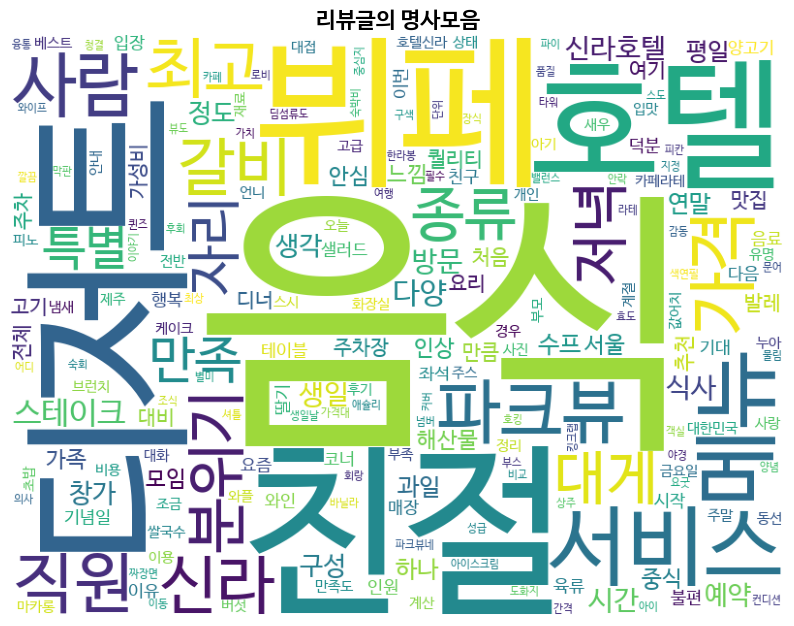

In [36]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier_string = df_to_string(s_hotel_buffet_review_outlier, "Review_Text")

s_hotel_buffet_review_nouns = kiwi_noun_extractor(s_hotel_buffet_review_outlier_string)
wordcloud_noun(s_hotel_buffet_review_nouns)

#### 형용사/동사 분리

In [37]:
# Setting
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    """kiwipiepy패키지를 이용해서 형용사,동사를 분류하는 함수"""
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

def wordcloud_verb_adj(verb_adj_text):
    """워드클라우드를 통해 시각화하는 함수"""
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    title_font = {
        'fontsize': 16,
        'fontweight': 'bold'
    }
    plt.title("리뷰글의 형용사/동사모음", fontdict=title_font)
    plt.show()

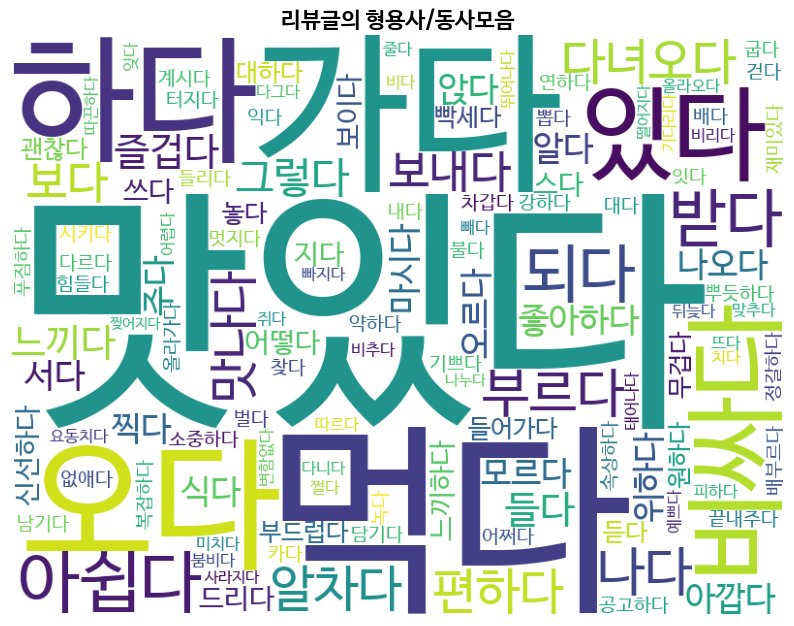

In [38]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier_string = df_to_string(s_hotel_buffet_review_outlier, "Review_Text")

s_hotel_buffet_review_verb_adj = kiwi_verb_adj_extractor(s_hotel_buffet_review_outlier_string)
wordcloud_verb_adj(s_hotel_buffet_review_verb_adj)

### '만족도', '맛', '서비스', '가격' 총 네가지로 나누어 긍정/부정 분류

In [39]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI



In [69]:
class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_parse_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
    for sentence in df["Review_Text"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["만족도"].append(test_result["만족도"])
        temp["맛"].append(test_result["맛"])
        temp["서비스"].append(test_result["서비스"])
        temp["가격"].append(test_result["가격"])

    df["만족도"] = temp["만족도"]
    df["맛"] = temp["맛"]
    df["서비스"] = temp["서비스"]
    df["가격"] = temp["가격"]
    
    df.to_csv("./S_hotel_buffet_review_parse.csv")
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""


In [63]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier = s_hotel_buffet_review_outlier.drop('Unnamed: 0', axis = 1)

chain = MyChain(template=template)

s_hotel_buffet_parse_review = save_parse_reviews(s_hotel_buffet_review_outlier, chain)

In [64]:
s_hotel_buffet_parse_review.head(10)

UserID                                        Review_Text  \
0   illiiilillil  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   
1      shooooooo                                  종류도 알차게 많고 다 맛있어요   
2        Choigo다  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...   
3         shekyh  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...   
4           이진욱쨩                                  항상 친절하시고 음식도 맛있네요   
5           KSL1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...   
6       juehhhhh  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   
7  Reinyourheart  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...   
8            블리랩  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...   
9          미국주식왕            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   

                Date NumberOfVisit 만족도   맛 서비스  가격  
0   2024년 5월 19일 일요일        1번째 방문  긍정  긍정  긍정   -  
1    2024년 6월 7일 금요일        1번째 방문  긍정  긍정   -   -  
2    2024년 3월 3일 일요일        1번째 방문  긍정   -  긍정  부정  
3    2024년 2월 3일 토요일        1번째 방문  긍정  부정  긍정   -  
4   2024년 4월 21일 일요일        2번째 방문  긍정  긍정  긍정   -  
5  2023년 12월 13일 수요일        1번째 방문  긍정  긍정   -  부정  
6   2024년 2월 25일 일요일        1번째 방문  긍정  긍정   -  부정  
7    2024년 1월 9일 화요일        1번째 방문  긍정  긍정   -  부정  
8  2023년 11월 14일 화요일        1번째 방문  긍정  긍정  긍정   -  
9   2024년 3월 10일 일요일        1번째 방문  긍정  긍정   -  부정

### 긍/부정으로 분류된 데이터들을 시각화하여 분석하기/나타내기

In [23]:
import pandas as pd

s_hotel_buffet_review_parsed = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
review = s_hotel_buffet_review_parsed.copy()

#### 각 카테고리별 긍/부정평가 갯수 확인

In [12]:
# Setting
def emotion_eval_counts(df, column_name):
    """긍정/부정/- 갯수 추출하는 함수"""
    return df[column_name].value_counts()

In [167]:
# 실행
print(emotion_eval_counts(review, "만족도"))
# print(emotion_eval_counts(review, "맛"))
# print(emotion_eval_counts(review, "서비스"))
print(emotion_eval_counts(review, "가격"))

만족도
긍정    150
부정     11
-      10
Name: count, dtype: int64
가격
-     100
부정     59
긍정     12
Name: count, dtype: int64


#### 각 카테고리별 긍/부정갯수 막대그래프 시각화

In [13]:
# 한글 글꼴 설정
import matplotlib.pyplot as plt
import numpy as np
font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

In [14]:
# Setting
def s_hotel_review_emote_bar(emote1,emote2,emote3,emote4):
    """카테고리 4개인 막대그래프 만드는 함수"""
    x = np.arange(4)
    
    satisf_Aemo = emote1["긍정"] + emote1["부정"]
    taste_Aemo = emote2["긍정"] + emote2["부정"]
    service_Aemo = emote3["긍정"] + emote3["부정"]
    price_Aemo = emote4["긍정"] + emote4["부정"]
    
    y_axis = [satisf_Aemo,taste_Aemo,service_Aemo,price_Aemo]
    x_axis = ["만족도","맛","서비스","가격"]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.title("카테고리별 긍/부정 갯수")
    plt.show()

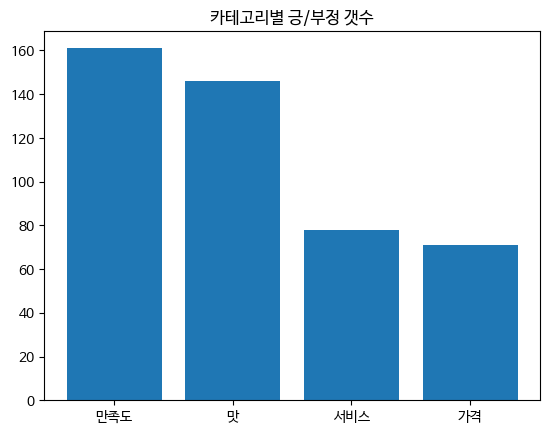

In [15]:
# 실행
satisfy_emote = emotion_eval_counts(review, "만족도")
taste_emote = emotion_eval_counts(review, "맛")
service_emote = emotion_eval_counts(review, "서비스")
price_emote = emotion_eval_counts(review, "가격")

s_hotel_review_emote_bar(satisfy_emote,taste_emote,service_emote,price_emote)

#### 각 카테고리별 긍/부정 비율 Pie 그래프 시각화

In [16]:
satisfy_emo = emotion_eval_counts(review, "만족도")
taste_emo = emotion_eval_counts(review, "맛")
service_emo = emotion_eval_counts(review, "서비스")
price_emo = emotion_eval_counts(review, "가격")

In [17]:
satisfy_total = satisfy_emo["긍정"] + satisfy_emo["부정"]
taste_total = taste_emo["긍정"] + taste_emo["부정"]
service_total = service_emo["긍정"] + service_emo["부정"]
price_total = price_emo["긍정"] + price_emo["부정"]

In [18]:
def percent_emotion(reviews, total_number):
    return reviews / total_number * 100

In [19]:
satisfy_positive = percent_emotion(satisfy_emo["긍정"], satisfy_total)
satisfy_negative = percent_emotion(satisfy_emo["부정"], satisfy_total)

taste_positive = percent_emotion(taste_emo["긍정"], taste_total)
taste_negative = percent_emotion(taste_emo["부정"], taste_total)

service_positive = percent_emotion(service_emo["긍정"], taste_total)
service_negative = percent_emotion(service_emo["부정"], taste_total)

price_positive = percent_emotion(price_emo["긍정"], price_total)
price_negative = percent_emotion(price_emo["부정"], price_total)


In [20]:
import matplotlib.pyplot as plt

def pie_chart(positive, negative, keyword):
    ratio = [positive, negative]
    labels = ["긍정", "부정"]
    colors = ["#00539C", "#EEA47F"]
    plt.title("{} 긍/부정 비율".format(keyword))
    plt.pie(ratio, labels= labels, autopct='%.1f%%', colors = colors)
    plt.show()

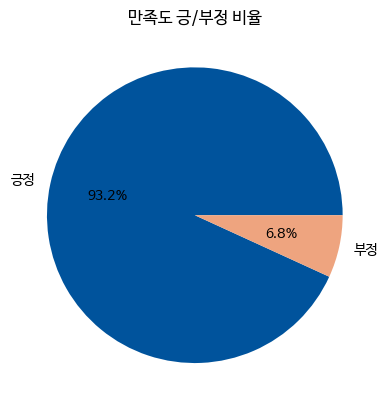

In [11]:
pie_chart(satisfy_positive, satisfy_negative, "만족도")

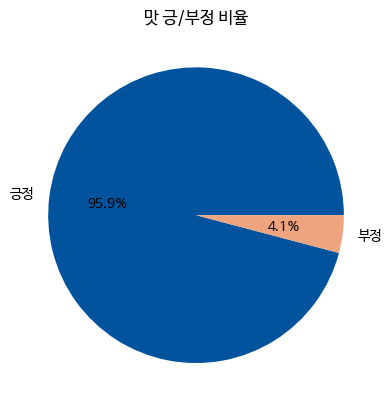

In [21]:
pie_chart(taste_positive, taste_negative, "맛")

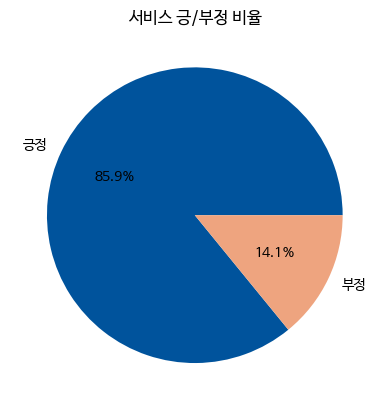

In [22]:
pie_chart(service_positive,service_negative, "서비스")

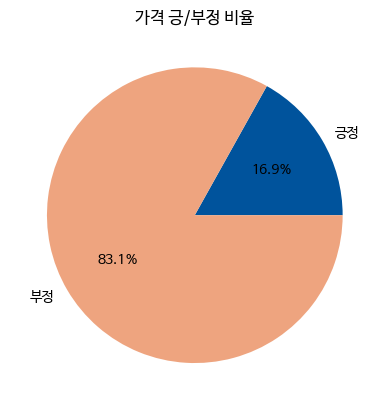

In [12]:
pie_chart(price_positive, price_negative, "가격")

#### 각각의 긍/부정 리뷰글들의 명사, 동사/형용사 추출 및 시각화

##### `만족도` 긍정 리뷰글들의 명사 추출 및 시각화

In [74]:
# Setting
def positive_review_extractor(df, string_column, category_column):
    """카테고리에 긍정으로 표시된 리뷰글만 추출하는 함수

    Args:
        df (_type_): 데이터프레임
        string_column (_type_): 리뷰글항목
        category_column (_type_): 카테고리명
    """
    positive_reviews = {"긍정":[]}
    for i in range(len(df)):
        if df[category_column][i] == "긍정":
            positive_reviews["긍정"].append(df[string_column][i])
            
    return positive_reviews

In [5]:
# 실행
satisfy_review = positive_review_extractor(review, "Review_Text","만족도")

In [6]:
satisfy_review_df = pd.DataFrame(satisfy_review)

In [183]:
satisfy_review_df.head()

긍정
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...
1                                  종류도 알차게 많고 다 맛있어요
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...
4                                  항상 친절하시고 음식도 맛있네요

In [73]:
# Setting
def positive_review_string_extractor(df):
    """딕셔너리로 받은 리뷰글 string으로 추출하는 함수"""
    for key, value in df.items():
        df[key] = ', '.join(value)
        
    positive_string = df.get("긍정")
    return positive_string

In [132]:
# 실행
satisfy_positive_string = positive_review_string_extractor(satisfy_review)

In [85]:
# Setting
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    """명사 추출하는 함수"""
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [86]:
satisfy_reviews_noun = kiwi_noun_extractor(satisfy_positive_string)

In [153]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    """명사만 워드클라우드로 나타내는 함수"""
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("만족도 긍정 리뷰글의 명사모음", fontdict=title_font)
    plt.show()

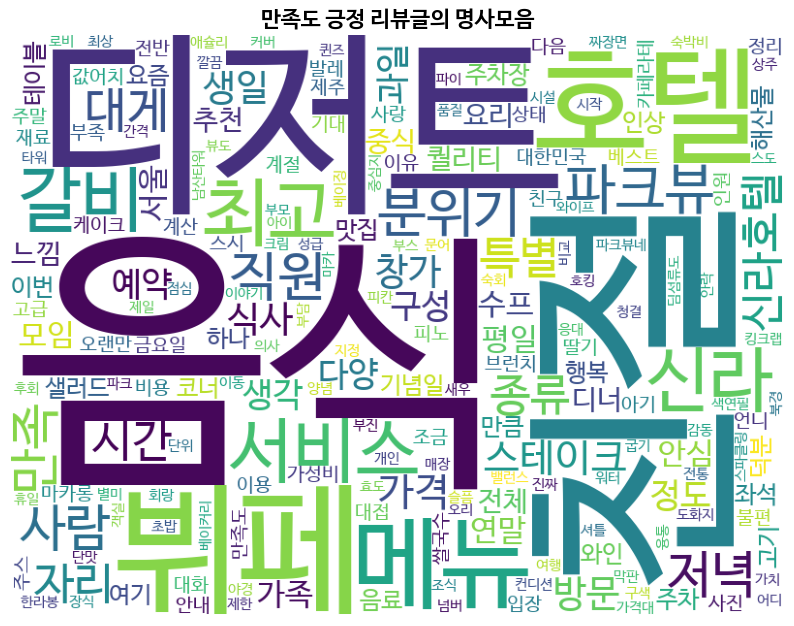

In [88]:
# 실행
wordcloud_noun(satisfy_reviews_noun)

##### `만족도` 긍정 리뷰글들의 동사/형용사 추출및 시각화

In [154]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    """동사/형용사 추출하는 함수"""
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [134]:
satisfy_reviews_verb_adj = kiwi_verb_adj_extractor(satisfy_positive_string)

In [155]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    """동사/형용사를 워드클라우드로 나타내는 함수"""
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("만족도 긍정 리뷰글의 동사/형용사 모음", fontdict=title_font)
    plt.show()

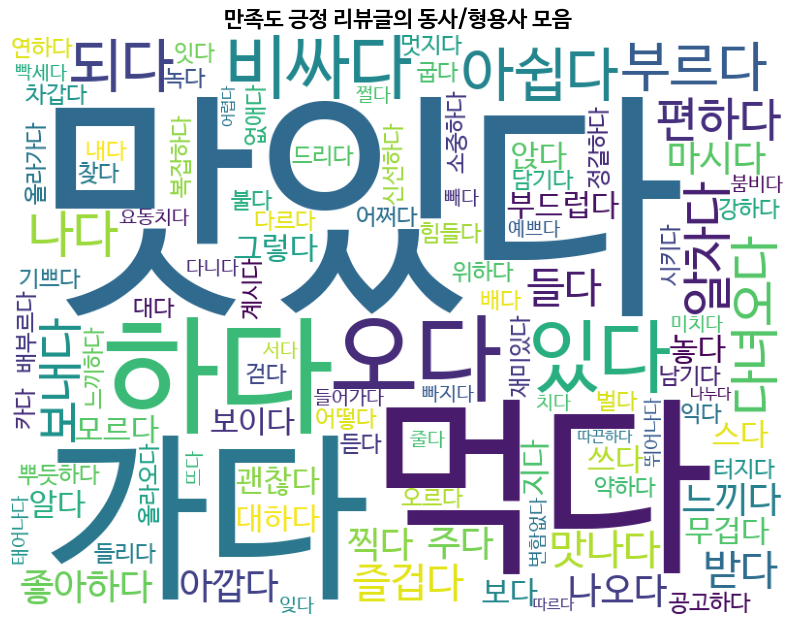

In [136]:
wordcloud_verb_adj(satisfy_reviews_verb_adj)

##### `가격` 부정 리뷰글들의 명사 추출 및 시각화

In [75]:
# 실행
def negative_review_extractor(df, string_column, category_column):
    """카테고리에 부정으로 표시된 리뷰글만 추출하는 함수

    Args:
        df (_type_): 데이터프레임
        string_column (_type_): 리뷰글항목
        category_column (_type_): 카테고리명
    """
    negative_reviews = {"부정":[]}
    # 가격항목에 부정이라 평가된 리뷰글만 추출
    for i in range(len(df)):
        if df[category_column][i] == "부정":
            negative_reviews["부정"].append(df[string_column][i])
    return negative_reviews

In [146]:
price_reviews = negative_review_extractor(review, "Review_Text","가격")

In [147]:
# Setting
def negative_review_string_extractor(df):
    """딕셔너리로 받은 리뷰글 추출하는 함수"""
    for key, value in df.items():
        df[key] = ', '.join(value)
        
    negative_string = df.get("부정")
    return negative_string

In [148]:
# 실행
price_negative_string = negative_review_string_extractor(price_reviews)

In [92]:
# Setting
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    """명사 추출하는 함수"""
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [99]:
price_reviews_noun = kiwi_noun_extractor(price_negative_string)

In [156]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    """명사만 워드클라우드로 나타내는 함수"""
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("가격 부정 리뷰글의 명사모음", fontdict=title_font)
    plt.show()

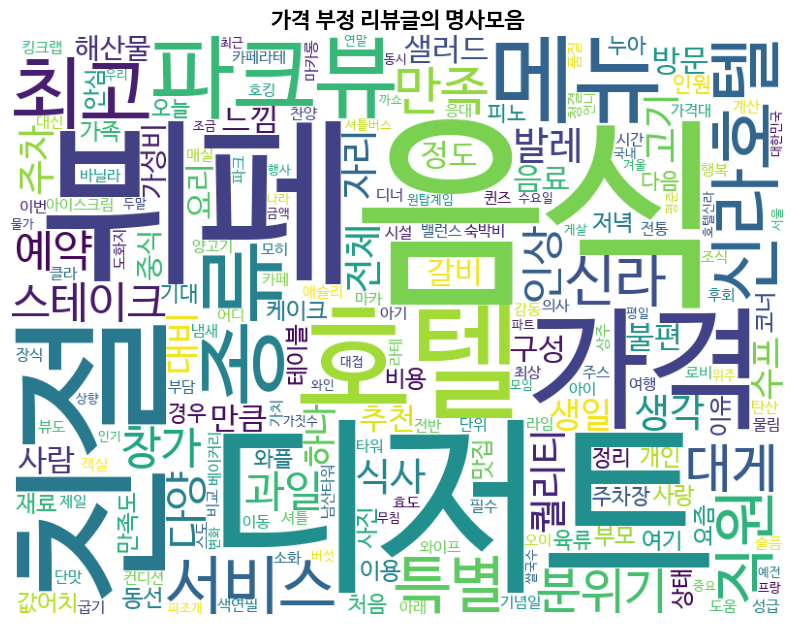

In [100]:
# 실행
wordcloud_noun(price_reviews_noun)

##### `가격` 부정 리뷰글들의 동사/형용사추출 및 시각화

In [158]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    """동사/형용사를 추출하는 함수"""
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [150]:
price_reviews_verb_adj = kiwi_verb_adj_extractor(price_negative_string)

In [157]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    """동사/형용사를 워드클라우드로 나타내는 함수"""
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("가격 부정 리뷰글의 동사/형용사 모음", fontdict=title_font)
    plt.show()

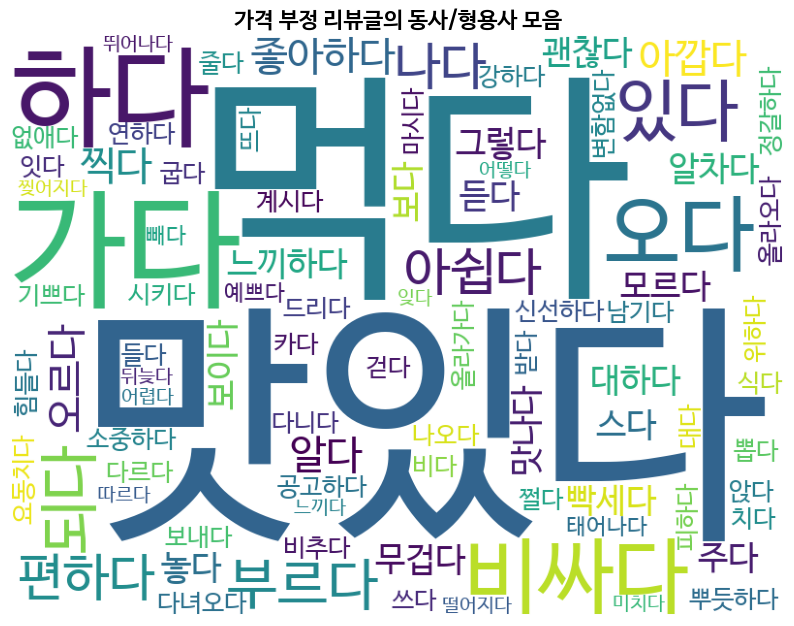

In [170]:
# 실행
wordcloud_verb_adj(price_reviews_verb_adj)

### 피드백

#### `만족도` 긍정 리뷰글, `가격` 부정 리뷰글 빈도수 제일 많은 3개의 명사 추출 및 긍정/부정 분류

##### 만족도 긍정 리뷰글 추출

In [85]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [78]:
satisfy_reviews = positive_review_extractor(review, "Review_Text", "만족도")

In [79]:
satisfy_review_df = pd.DataFrame(satisfy_reviews)
satisfy_review_df.head()

긍정
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...
1                                  종류도 알차게 많고 다 맛있어요
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...
4                                  항상 친절하시고 음식도 맛있네요

##### `만족도` 긍정 리뷰글 빈도 높은 명사 긍정/ 부정 분류

In [ ]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_satisfy_positive_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"디저트": [], "음식":[], "친절":[]}
    for sentence in df["긍정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["디저트"].append(test_result["디저트"])
        temp["음식"].append(test_result["음식"])
        temp["친절"].append(test_result["친절"])

    df["디저트"] = temp["디저트"]
    df["음식"] = temp["음식"]
    df["친절"] = temp["친절"]

    
    df.to_csv("./satisfy_review_nouns_emotion_classify.csv", index = False)
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '디저트', '음식', '친절'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "디저트": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "친절": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [ ]:
# 실행

chain = MyChain(template=template)

satisfy_positive_parse_review = save_satisfy_positive_reviews(satisfy_review_df, chain)

##### 가격 부정 리뷰글 추출

In [80]:
price_reviews = negative_review_extractor(review, "Review_Text","가격")

In [81]:
price_review_df = pd.DataFrame(price_reviews)
price_review_df.head()

부정
0  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...
1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...
2  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...
3  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...
4            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집

##### `가격` 부정 리뷰글 빈도 높은 명사 긍정/부정 분류

In [ ]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_price_negative_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"뷔페": [], "음식":[], "디저트":[]}
    for sentence in df["부정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["뷔페"].append(test_result["뷔페"])
        temp["음식"].append(test_result["음식"])
        temp["디저트"].append(test_result["디저트"])

    df["뷔페"] = temp["뷔페"]
    df["음식"] = temp["음식"]
    df["디저트"] = temp["디저트"]

    
    df.to_csv("./price_review_nouns_emotion_classify.csv", index = False)
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '뷔페', '음식', '디저트'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "뷔페": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "디저트": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [ ]:
# 실행

chain = MyChain(template=template)

price_negative_parse_review = save_price_negative_reviews(price_review_df, chain)

#### 빈도 높은 명사들의 총 긍/부정 갯수와 비율 시각화

##### 빈도 높은 명사들의 총 긍/부정 갯수

In [191]:
# Setting
def noun_emote_bar(emote1,emote2,emote3, column_name1, column_name2, column_name3, keyword):
    """카테고리 4개인 막대그래프 만드는 함수"""
    x = np.arange(3)
    
    all_emo1 = emote1["긍정"] + emote1["부정"]
    all_emo2 = emote2["긍정"] + emote2["부정"]
    all_emo3 = emote3["긍정"] + emote3["부정"]
    
    y_axis = [all_emo1,all_emo2,all_emo3]
    x_axis = [column_name1,column_name2,column_name3]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.title("{} 긍/부정 갯수".format(keyword))
    plt.show()

In [ ]:
# 만족도 긍정 리뷰글 빈도 높은 명사
dessert_pos_emo = emotion_eval_counts(satisfy_positive_parse_review, "디저트")
food_pos_emo = emotion_eval_counts(satisfy_positive_parse_review, "음식")
kindness_emo = emotion_eval_counts(satisfy_positive_parse_review, "친절")

# 가격 부정 리뷰글 빈도 높은 명사
buffet_emo = emotion_eval_counts(price_negative_parse_review, "뷔페")
food_neg_emo = emotion_eval_counts(price_negative_parse_review, "음식")
dessert_neg_emo = emotion_eval_counts(price_negative_parse_review, "디저트")

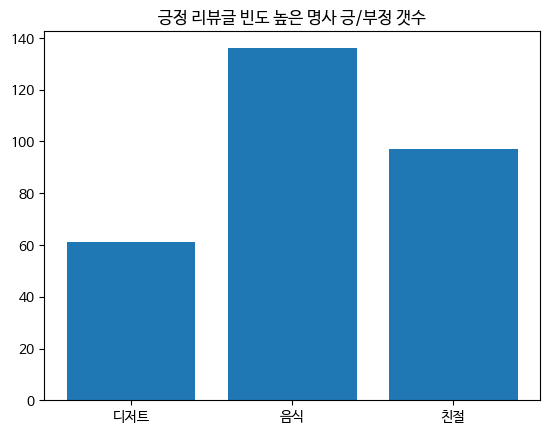

In [192]:
noun_emote_bar(dessert_pos_emo, food_pos_emo, kindness_emo, "디저트","음식", "친절", "긍정 리뷰글 빈도 높은 명사")

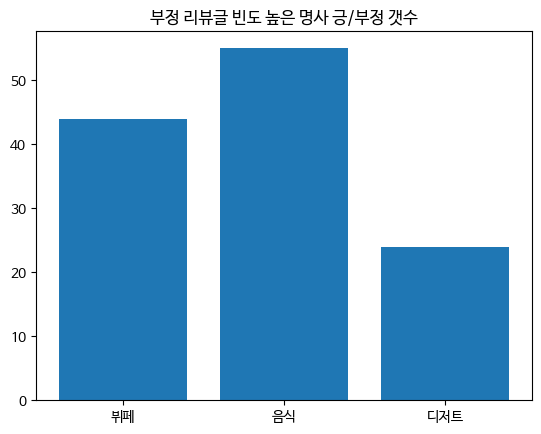

In [193]:
noun_emote_bar(buffet_emo,food_neg_emo,dessert_neg_emo,"뷔페","음식","디저트","부정 리뷰글 빈도 높은 명사")

##### 빈도 수 높은 명사들의 긍/부정 비율 시각화

###### `만족도` 긍정 리뷰글 빈도 높은 명사들 긍/부정 비율

In [13]:
def percent_emotion(reviews, total_number):
    """퍼센트 구하는 함수"""
    return reviews / total_number * 100

In [ ]:
# 긍/부정 총 갯수 구하기
dessert_pos_total= dessert_pos_emo["긍정"] + dessert_pos_emo["부정"]
food_pos_total=food_pos_emo["긍정"] + food_pos_emo["부정"]
kindness_total = kindness_emo["긍정"] + kindness_emo["부정"]

In [ ]:
dessert_positive_pos = percent_emotion(dessert_pos_emo["긍정"], dessert_pos_total)
food_positive_pos = percent_emotion(food_pos_emo["긍정"], food_pos_total)
kindness_pos = percent_emotion(kindness_emo["긍정"], kindness_total)


dessert_positive_neg = percent_emotion(dessert_pos_emo["부정"], dessert_pos_total)
food_positive_neg = percent_emotion(food_pos_emo["부정"], food_pos_total)
kindness_neg = percent_emotion(kindness_emo["부정"], kindness_total)

In [ ]:
# 원그래프
import matplotlib.pyplot as plt

def pie_chart(positive, negative, keyword):
    """항목 2개인 Pie Chart 만드는 함수"""
    ratio = [positive, negative]
    labels = ["긍정", "부정"]
    colors = ["#00539C", "#EEA47F"]
    plt.title("{} 긍/부정 비율".format(keyword))
    plt.pie(ratio, labels= labels, autopct='%.1f%%', colors = colors)
    plt.show()

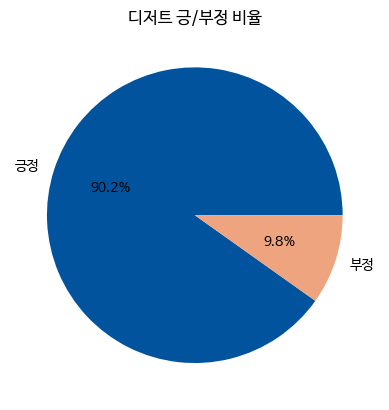

In [ ]:
pie_chart(dessert_positive_pos, dessert_positive_neg, "디저트")

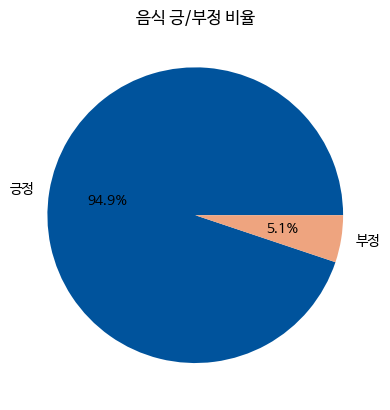

In [ ]:
pie_chart(food_positive_pos, food_positive_neg, "음식")

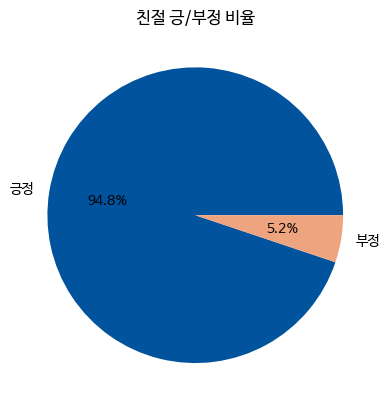

In [ ]:
pie_chart(kindness_pos,kindness_neg,"친절")

###### `가격` 부정 리뷰글 빈도 높은 명사들 긍/부정 비율

In [ ]:
# 부정 리뷰글 총 긍/부정 갯수 구하기
buffet_total = buffet_emo["긍정"] + buffet_emo["부정"]
food_neg_total = food_neg_emo["긍정"] + food_neg_emo["부정"]
dessert_neg_total = dessert_neg_emo["긍정"] + dessert_neg_emo["부정"]

In [ ]:
buffet_pos = percent_emotion(buffet_emo["긍정"], buffet_total)
food_negative_pos = percent_emotion(food_neg_emo["긍정"], food_neg_total)
dessert_negative_pos = percent_emotion(dessert_neg_emo["긍정"], dessert_neg_total)

buffet_neg = percent_emotion(buffet_emo["부정"], buffet_total)
food_negative_neg = percent_emotion(food_neg_emo["부정"], food_neg_total)
dessert_negative_neg = percent_emotion(dessert_neg_emo["부정"], dessert_neg_total)

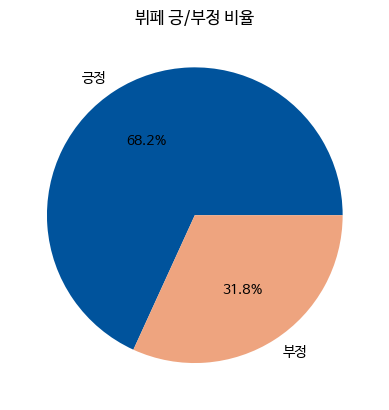

In [ ]:
pie_chart(buffet_pos, buffet_neg,"뷔페")

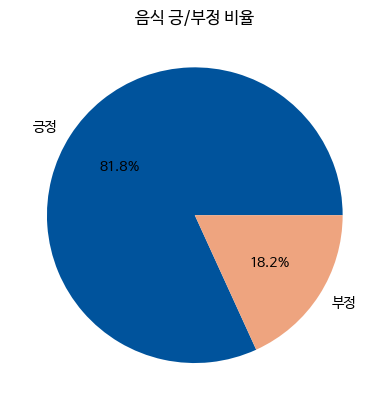

In [ ]:
pie_chart(food_negative_pos, food_negative_neg, "음식")

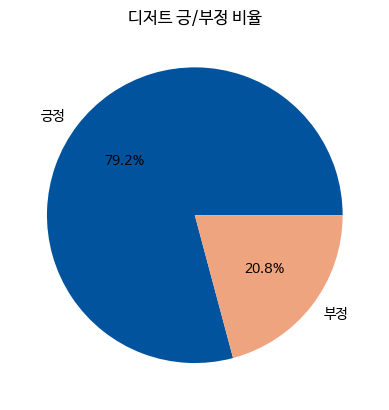

In [ ]:
pie_chart(dessert_negative_pos, dessert_negative_neg, "디저트")

##### 디저트 키워드 언급된 횟수 세기

In [ ]:
temp_string_reviews = {"ALL":[]}

for i in range(len(temp_review)):
    temp_string_reviews["ALL"].append(temp_review["Review_Text"][i])

In [ ]:
for key, value in temp_string_reviews.items():
    temp_string_reviews[key] = ', '.join(value)
    
review_string1 = temp_string_reviews.get("ALL")

In [ ]:
dessert_counts = review_string1.count("디저트")

print("만족도 카테고리의 긍정 리뷰글에서 디저트 키워드가 언급된 횟수는 {}회 입니다.".format(dessert_counts))

만족도 카테고리의 긍정 리뷰글에서 디저트 키워드가 언급된 횟수는 29회 입니다.


In [86]:


def review_emote_bar(counts):
    """카테고리 1개인 막대그래프 만드는 함수"""
    x = np.arange(1)

    y_axis = [counts]
    x_axis = ["디저트"]
    
    plt.figure(figsize = (4,6))
    bar = plt.bar(x,y_axis, width=0.2)
    plt.xticks(x, x_axis)
    plt.ylabel("횟수")
    plt.xlabel("키워드")
    plt.xlim(-0.5,0.5)
    plt.title("디저트 키워드가 언급된 횟수")
    
    for rect in bar:
        height =rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center',va='bottom',size=12)
    plt.show()

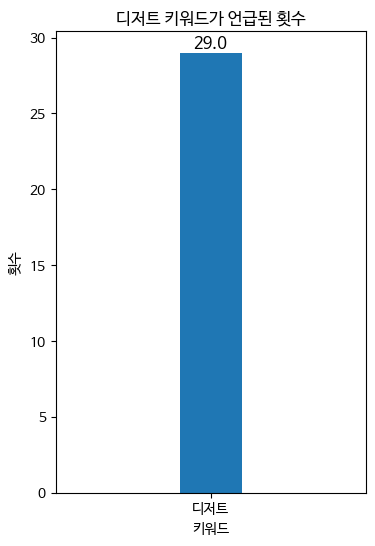

In [87]:
review_emote_bar(dessert_counts)

---

## 연습

In [1]:
import pandas as pd

In [2]:
temp_review_strlength = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")

In [3]:
review_strlist = temp_review_strlength["Review_Text"].to_list()
review_string = ''.join(str(s) for s in review_strlist)

In [17]:
review_string[:20]

'직원 분들 너무 친절하시고 음식 맛은'

---

### 1. 형태소 분리

1. 명사 분류하기
    - 시각화
2. 동사, 형용사 분류하기
    - 시각화

#### 1. 명사

In [7]:
# 1. 명사 분류하기
# from konlpy.tag import Okt
# okt = Okt()

# def okt_noun_extractor(text):
#     return okt.nouns(text)

In [30]:
# kiwi 명사 추출 함수
from kiwipiepy import Kiwi
kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [31]:
# review_nouns = okt_noun_extractor(review_string)
review_nouns = kiwi_noun_extractor(review_string)

In [32]:
# - 명사 시각화 하기
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

##### 문제점: `okt`를 사용시 명사라고 보기 어려운 것도 명사로 인식되어 나오게 됨.

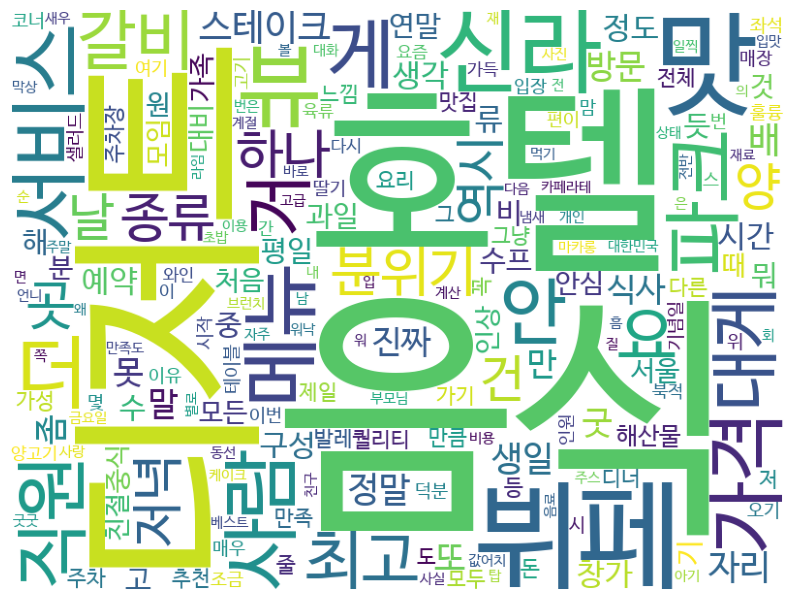

In [11]:
wordcloud_noun(review_nouns)

- 위의 명사를 통해 디저트, 호텔, 음식에 대한 키워드가 많이 나왔고, 메뉴, 사람, 가격등의 단어가 분포가 그다음으로 많음.

##### 해결법: `Kiwipiepy`를 사용하여 명사를 분류하니 okt보다 명사로 잘 분류되어 시각화 잘됨.

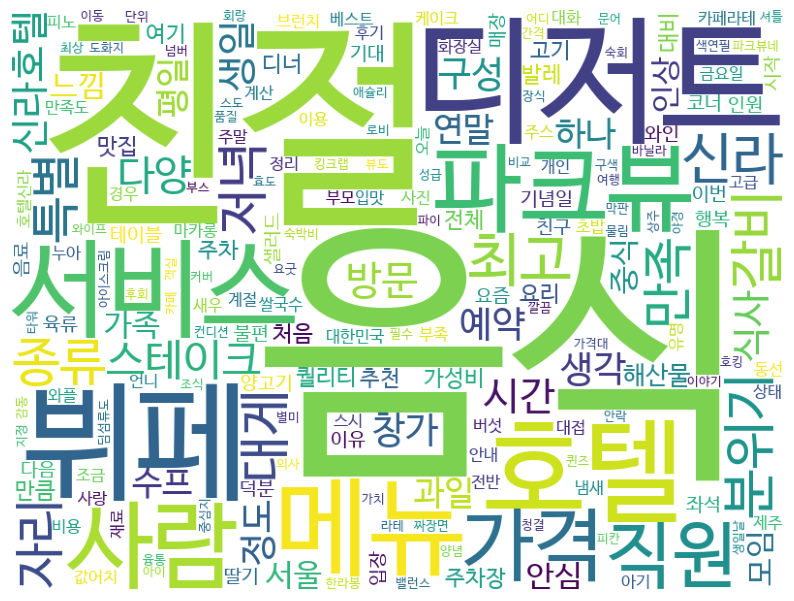

In [33]:
wordcloud_noun(review_nouns)

- 위의 워드클라우드를 통해 `친절`, `음식` 등의 단어가 제일 많이 분포되어 있고 그뒤로 `서비스`, `디저트`,`분위기`등의 단어들이 분포가 된다.

#### 2. 동사 / 형용사

In [18]:
# 동사 / 형용사 분류하기

def okt_adj_verb_extractor(text):
    results = []
    result = okt.pos(text)
    
    for token, pos in result:
        if len(token) != 1 and pos.startswith('Adj'): #or pos.startswith('Verb'):
            results.append(token)
    return results

In [37]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [38]:
# review_adj_verb_okt = okt_adj_verb_extractor(review_string)
review_adj_verb_temp = kiwi_verb_adj_extractor(review_string)
# review_adj_verb = list(map(lambda x : x + '다',results))

In [34]:
# review_adj_verb_temp

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    plt.show()

##### 문제점: `okt`를 사용하니 같은 의미지만 다른 형태로 나오게 되어 시각화할시 중복되어 나오게 되어 본질을 흐림.

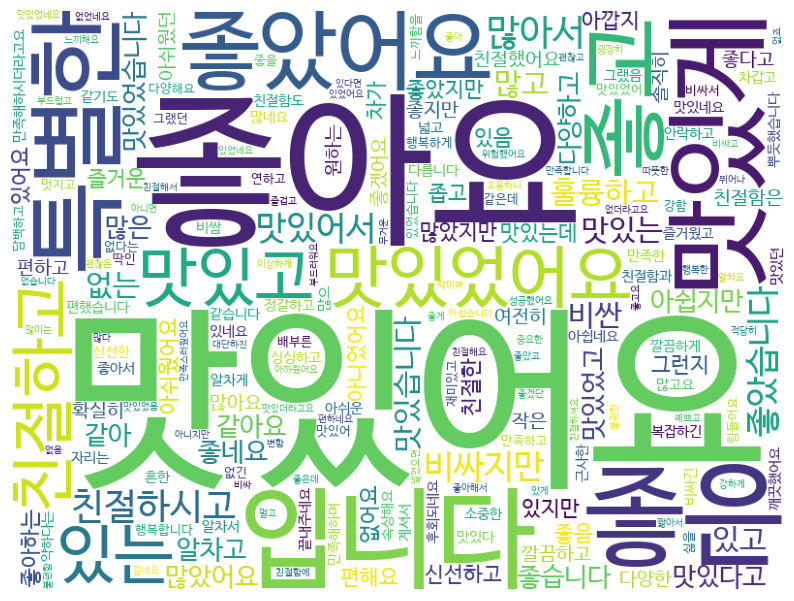

In [35]:
wordcloud_verb_adj(review_adj_verb_okt)

##### 해결법: `Kiwipiepy`를 사용하니 중복되는 단어 없이 분류가 잘되어 시각화가 잘나타나짐.

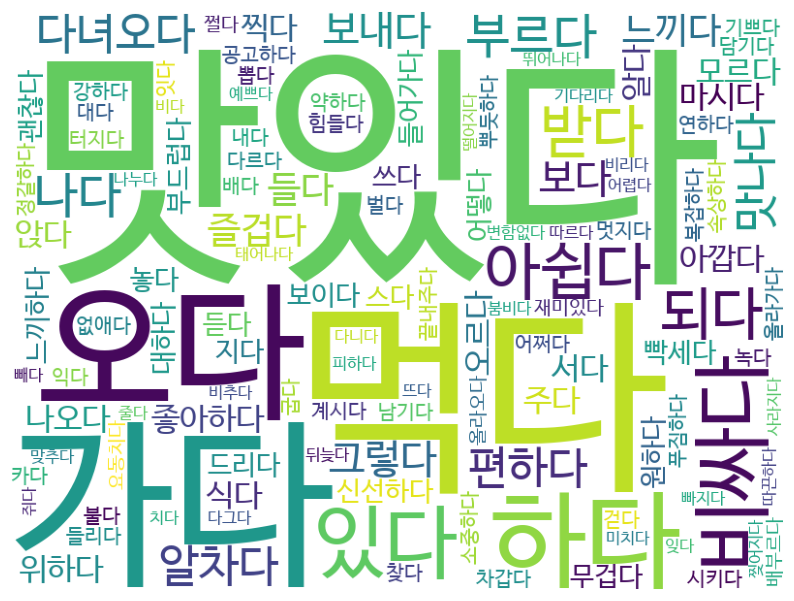

In [40]:
wordcloud_verb_adj(review_adj_verb_temp)

---

### 2. 네이버 키워드 리뷰를 통해 '만족도', '맛', '서비스', '가격' 총 네가지로 나누어 긍정/부정 분류

In [48]:
import os
import pandas as pd
import json
from dotenv import load_dotenv

load_dotenv()

True

In [49]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

#### 문제점1: 각 음식에 대한 긍정/ 부정 확인이 필요하다고 생각함

#### 해결방법: 프롬프트로 각 음식에 대한 긍정/ 부정으로 출력하게 한다.

In [7]:
from langchain_core.prompts import PromptTemplate

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 긍정적인 평가와 부정적인 평가가 함께 있는 경우, 
  모든 '맛'평가의 대상음식과 긍정/부정적인 평가를 다 출력하세요
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": '음식1 긍정/부정/-, 음식2 긍정/부정/-, ...'
    "서비스": "긍정/부정/-"
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | llm

In [9]:
temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
# temp_test_review = temp_test_review.drop('Unnamed: 0', axis = 1)
for sentence in temp_test_review["Review_Text"]:
    emo_eval = chain.invoke({"sentence":sentence})
    test_result = json.loads(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])

In [11]:
temp_test_review["만족도"] = temp_test["만족도"]
temp_test_review["맛"] = temp_test["맛"]
temp_test_review["서비스"] = temp_test["서비스"]
temp_test_review["가격"] = temp_test["가격"]

#### 문제점2: 프롬프트에 너무 많은 일을 시키게 되어 과부하 비슷한 일이 걸림.

In [12]:
temp_test_review.head()

UserID                                        Review_Text  \
0  illiiilillil  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   
1     shooooooo                                  종류도 알차게 많고 다 맛있어요   
2       Choigo다  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...   
3        shekyh  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...   
4          이진욱쨩                                  항상 친절하시고 음식도 맛있네요   

               Date NumberOfVisit 만족도                                     맛  \
0  2024년 5월 19일 일요일        1번째 방문  긍정                         고기 부정, 샐러드 긍정   
1   2024년 6월 7일 금요일        1번째 방문  긍정                         고기 부정, 샐러드 긍정   
2   2024년 3월 3일 일요일        1번째 방문  긍정                                     -   
3   2024년 2월 3일 토요일        1번째 방문  긍정  대게 부정, 짜장면 부정, 양갈비 긍정, 딸기 긍정, 한라봉 긍정   
4  2024년 4월 21일 일요일        2번째 방문  긍정                                 음식 부정   

  서비스  가격  
0  긍정   -  
1   -   -  
2  긍정  부정  
3  긍정   -  
4  긍정   -

#### 헤결방법: 원래는 멀티체인을 이용해야하지만 이건 어디까지나 실습용이기에 그냥 프롬프트로 분류 되는데로 하기로 함.

In [18]:
from langchain_core.prompts import PromptTemplate

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | llm

In [19]:
temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
# temp_test_review = temp_test_review.drop('Unnamed: 0', axis = 1)
for sentence in temp_test_review["Review_Text"]:
    emo_eval = chain.invoke({"sentence":sentence})
    test_result = json.loads(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])

In [21]:
temp_test_review = temp_review.copy()
temp_test_review["만족도"] = temp_test["만족도"]
temp_test_review["맛"] = temp_test["맛"]
temp_test_review["서비스"] = temp_test["서비스"]
temp_test_review["가격"] = temp_test["가격"]

In [22]:
temp_test_review.head(10)

Unnamed: 0         UserID  \
0           0   illiiilillil   
1           1      shooooooo   
2           2        Choigo다   
3           3         shekyh   
4           4           이진욱쨩   
5           5           KSL1   
6           6       juehhhhh   
7           7  Reinyourheart   
8           8            블리랩   
9           9          미국주식왕   

                                         Review_Text               Date  \
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   2024년 5월 19일 일요일   
1                                  종류도 알차게 많고 다 맛있어요    2024년 6월 7일 금요일   
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...    2024년 3월 3일 일요일   
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...    2024년 2월 3일 토요일   
4                                  항상 친절하시고 음식도 맛있네요   2024년 4월 21일 일요일   
5  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...  2023년 12월 13일 수요일   
6  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   2024년 2월 25일 일요일   
7  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...    2024년 1월 9일 화요일   
8  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...  2023년 11월 14일 화요일   
9            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   2024년 3월 10일 일요일   

  NumberOfVisit 만족도   맛 서비스  가격  
0        1번째 방문  긍정  긍정  긍정   -  
1        1번째 방문  긍정  긍정   -   -  
2        1번째 방문  긍정   -  긍정  부정  
3        1번째 방문  긍정  부정  긍정   -  
4        2번째 방문  긍정  긍정  긍정   -  
5        1번째 방문  긍정  긍정   -  부정  
6        1번째 방문  긍정  긍정   -   -  
7        1번째 방문  긍정  긍정   -  부정  
8        1번째 방문  긍정  긍정  긍정   -  
9        1번째 방문  긍정  긍정   -   -

#### 클래스를 이용한 프롬프트

In [52]:
class MyChain:
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""
temp_review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
temp_test_review2 = temp_review.copy()

chain = MyChain(template=template)

temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
for sentence in temp_test_review2["Review_Text"]:
    emo_eval = chain.invoke(sentence)
    test_result = parsing(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])


temp_test_review2["만족도"] = temp_test["만족도"]
temp_test_review2["맛"] = temp_test["맛"]
temp_test_review2["서비스"] = temp_test["서비스"]
temp_test_review2["가격"] = temp_test["가격"]

In [55]:
temp_test_review2.head(10)

Unnamed: 0         UserID  \
0           0   illiiilillil   
1           1      shooooooo   
2           2        Choigo다   
3           3         shekyh   
4           4           이진욱쨩   
5           5           KSL1   
6           6       juehhhhh   
7           7  Reinyourheart   
8           8            블리랩   
9           9          미국주식왕   

                                         Review_Text               Date  \
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   2024년 5월 19일 일요일   
1                                  종류도 알차게 많고 다 맛있어요    2024년 6월 7일 금요일   
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...    2024년 3월 3일 일요일   
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...    2024년 2월 3일 토요일   
4                                  항상 친절하시고 음식도 맛있네요   2024년 4월 21일 일요일   
5  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...  2023년 12월 13일 수요일   
6  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   2024년 2월 25일 일요일   
7  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...    2024년 1월 9일 화요일   
8  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...  2023년 11월 14일 화요일   
9            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   2024년 3월 10일 일요일   

  NumberOfVisit 만족도   맛 서비스  가격  
0        1번째 방문  긍정  긍정  긍정   -  
1        1번째 방문  긍정  긍정   -  긍정  
2        1번째 방문  긍정   -  긍정  부정  
3        1번째 방문  긍정  부정  긍정   -  
4        2번째 방문  긍정  긍정  긍정   -  
5        1번째 방문  긍정  긍정   -   -  
6        1번째 방문  긍정  긍정   -  부정  
7        1번째 방문  긍정  긍정   -  부정  
8        1번째 방문  긍정  긍정  긍정   -  
9        1번째 방문  긍정  긍정  긍정   -

---

### 2.5 멀티 체인 연결을 통한 프롬프트 작성 및 긍/부정 분류

Template 작성
- `만족도`, `맛`,`서비스`,`가격` 카테고리로 나누어 긍/부정 분류하기
- `맛`부분에서 긍/부정은 여러 음식으로 인해 다양하게 나올 수 있다.
- 음식을 나누어 긍/부정을 확인하고 이를 분류하고 맛에 대한 긍정/ 부정의 분류를 음식에서 긍정 개수와 부정 개수를 확인하여 제일 개수가 많은 것으로 분류한다.

내가 원하는 형식

    "만족도": 긍정/부정/-
    "맛": ""
    "음식1 : ""
    "음식2 : ""

형식에 대해 어떻게 저장해야 할지 고민이다.
- `맛`카테고리에 저장을 안시키고 따로 항목을 만들어서 저장을 시킨다. -> 무분별한 항목들이 생겨 분석에 차질이 생길 수 있다.  
                                                                                                                                
연구원님 아이디어
- `맛` 카테고리의 긍정, 부정으로 나누어 안에 문자열로 키워드를 받는다.
- "맛 긍정" : [], "맛 부정" : []

    "만족도": "긍정/부정/-"
    "맛 긍정" : []
    "맛 부정" : []
    "서비스" : "긍정/부정/-"
    "가격" : "긍정/부정/-"

In [43]:
import pandas as pd
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv
import re


load_dotenv()

True

In [3]:
review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Review_Analyzer/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
temp_review = review.copy()

In [4]:
ten_review = temp_review.head(10)
ten_review

Unnamed: 0         UserID  \
0           0   illiiilillil   
1           1      shooooooo   
2           2        Choigo다   
3           3         shekyh   
4           4           이진욱쨩   
5           5           KSL1   
6           6       juehhhhh   
7           7  Reinyourheart   
8           8            블리랩   
9           9          미국주식왕   

                                         Review_Text               Date  \
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   2024년 5월 19일 일요일   
1                                  종류도 알차게 많고 다 맛있어요    2024년 6월 7일 금요일   
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...    2024년 3월 3일 일요일   
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...    2024년 2월 3일 토요일   
4                                  항상 친절하시고 음식도 맛있네요   2024년 4월 21일 일요일   
5  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...  2023년 12월 13일 수요일   
6  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   2024년 2월 25일 일요일   
7  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...    2024년 1월 9일 화요일   
8  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...  2023년 11월 14일 화요일   
9            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   2024년 3월 10일 일요일   

  NumberOfVisit  
0        1번째 방문  
1        1번째 방문  
2        1번째 방문  
3        1번째 방문  
4        2번째 방문  
5        1번째 방문  
6        1번째 방문  
7        1번째 방문  
8        1번째 방문  
9        1번째 방문

In [14]:
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 평가가 긍정적이라면 맛 긍정항목에 긍정적이었던 키워드를 넣고, 부정적이라면 맛 부정항목에 부정적이었던 키워드를 넣어 분류하세요.
- 맛에 대한 평가가 긍정/부정 없는 경우 맛 긍정 항목과 맛 부정 항목에 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정":["키워드/-"]
    "맛 부정":["키워드/-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)

for i in range(len(ten_review)):
    result = await combined.abatch([{"sentence": ten_review.Review_Text[i]}])
    
    parsed_result = {k: json.loads(v) for k, v in result[0].items()}
    combined_result = {**parsed_result["satisfy"], **parsed_result["taste"], **parsed_result["service"], **parsed_result["price"]}
    print(combined_result)

{'만족도': '긍정', '맛 긍정': ['친절하시고', '융통성도 좋아요'], '맛 부정': ['과일류 구색이 약하다는'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['맛있어요/-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['양갈비', '달달', '새콤달콤'], '맛 부정': ['차갑고', '짜장면', '삭면', '안익은'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['맛있네요/-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['싱싱하고', '맛있'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['만족', '맛있다'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['음식 퀄리티가 최상', '디저트의 퀄리티도 남다름', '짓수도 많고요'], '맛 부정': ['-'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['알차다/내어주다/즐겁다'], '맛 부정': ['-'], '서비스': '긍정', '가격': '-'}


JSONDecodeError: Expecting ',' delimiter: line 3 column 5 (char 29)

In [15]:
ten_review.Review_Text[9]

'네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집'

In [16]:
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 평가가 긍정적이라면 맛 긍정항목에 긍정적이었던 키워드를 넣고, 부정적이라면 맛 부정항목에 부정적이었던 키워드를 넣어 분류하세요.
- 맛에 대한 평가가 없는 경우 맛 긍정 항목과 맛 부정 항목에 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정":["키워드/-"]
    "맛 부정":["키워드/-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)

for i in range(len(ten_review)):
    result = combined.batch([{"sentence": ten_review.Review_Text[i]}])
    
    # parsed_result = {k: json.loads(v) for k, v in result[0].items()}
    # combined_result = {**parsed_result["satisfy"], **parsed_result["taste"], **parsed_result["service"], **parsed_result["price"]}
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    print(combined_result)

{'만족도': '긍정', '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['맛있어요/-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['양갈비/달콤'], '맛 부정': ['차갑고/짜장면/삭면/안익은'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['맛있네요/-'], '맛 부정': ['-'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['신선하고', '맛있는', '만족했던', '싱싱한'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['음식 퀄리티 최상', '디저트 퀄리티 남'], '맛 부정': ['-'], '서비스': '긍정', '가격': '긍정'}
{'만족도': '긍정', '맛 긍정': ['알차다', '내어주다'], '맛 부정': ['-'], '서비스': '긍정', '가격': '-'}
{'만족도': '긍정', '맛 긍정': ['기쁨'], '맛 부정': ['카페라테'], '서비스': '긍정', '가격': '긍정'}


In [81]:
# 음식 관련 키워드를 넣어 분류하라는 템플릿

model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 평가가 긍정적이라면 맛 긍정항목에 긍정적이었던 음식 관련 키워드를 넣고, 부정적이라면 맛 부정항목에 부정적이었던 음식 관련 키워드를 넣어 분류하세요.
- 맛에 대한 평가가 없는 경우, 각각 '맛 긍정' 항목과 '맛 부정' 항목에 '-'을 표시하세요.
- '맛 긍정' 항목과 '맛 부정' 항목은 항상 출력되어야 합니다.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정":["키워드" / "-"]
    "맛 부정":["키워드" / "-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(temp_review)):
    result = combined.batch([{"sentence":temp_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("맛 긍정", "-"))
    columns["Taste Negative"].append(combined_result.get("맛 부정", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [101]:
# 맛 관련 키워드로 분류하라는 템플릿
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 평가가 긍정적이라면 맛 긍정항목에 긍정적이었던 맛 관련 키워드를 넣고, 부정적이라면 맛 부정항목에 부정적이었던 맛 관련 키워드를 넣어 분류하세요.
- 맛에 대한 평가가 없는 경우, 각각 '맛 긍정' 항목과 '맛 부정' 항목에 '-'을 표시하세요.
- '맛 긍정' 항목과 '맛 부정' 항목은 항상 출력되어야 합니다.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정":["키워드" / "-"]
    "맛 부정":["키워드" / "-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(temp_review)):
    result = combined.batch([{"sentence":temp_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("맛 긍정", "-"))
    columns["Taste Negative"].append(combined_result.get("맛 부정", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [102]:
review["Satisfaction"] = columns["Satisfaction"]
review["Taste Positive"] = columns["Taste Positive"]
review["Taste Negative"] = columns["Taste Negative"]
review["Service"] = columns["Service"]
review["Price"] = columns["Price"]

In [103]:
review.head(10)

UserID                                        Review_Text  \
0   illiiilillil  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   
1      shooooooo                                  종류도 알차게 많고 다 맛있어요   
2        Choigo다  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...   
3         shekyh  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...   
4           이진욱쨩                                  항상 친절하시고 음식도 맛있네요   
5           KSL1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...   
6       juehhhhh  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   
7  Reinyourheart  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...   
8            블리랩  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...   
9          미국주식왕            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   

                Date NumberOfVisit Satisfaction           Taste Positive  \
0   2024년 5월 19일 일요일        1번째 방문           긍정        [친절하시고, 융통성도 좋아요]   
1    2024년 6월 7일 금요일        1번째 방문           긍정                   [맛있어요]   
2    2024년 3월 3일 일요일        1번째 방문           긍정                        -   
3    2024년 2월 3일 토요일        1번째 방문           긍정        [맛있었어요, 달달, 새콤달콤]   
4   2024년 4월 21일 일요일        2번째 방문           긍정                     [맛있]   
5  2023년 12월 13일 수요일        1번째 방문           긍정              [신선하다, 맛있다]   
6   2024년 2월 25일 일요일        1번째 방문           긍정                    [맛있다]   
7    2024년 1월 9일 화요일        1번째 방문           긍정  [음식 퀄리티 최상, 디저트 퀄리티 좋음]   
8  2023년 11월 14일 화요일        1번째 방문           긍정              [알차다, 내어주다]   
9   2024년 3월 10일 일요일        1번째 방문           긍정               [카페라테, 기쁨]   

           Taste Negative Service Price  
0          [과일류 구색이 약하다는]      긍정     -  
1                     [-]      긍정    긍정  
2                       -      긍정    긍정  
3  [차갑고, 짜고, 불어 있고, 안 익은]      긍정    긍정  
4                     [-]      긍정     -  
5                     [-]      긍정    긍정  
6                     [-]      긍정    긍정  
7                     [-]      긍정    긍정  
8                     [-]      긍정     -  
9                     [-]      긍정    긍정

In [104]:
review.to_csv("./improved_classify_review.csv", index = False, encoding="utf-8")

In [105]:
review = pd.read_csv("./improved_classify_review.csv")

In [106]:
import ast

for i in range(len(review)):
    try:
        review.loc[i, "Taste Positive"] = ", ".join(ast.literal_eval(review["Taste Positive"][i]))
        review.loc[i, "Taste Negative"] = ", ".join(ast.literal_eval(review["Taste Negative"][i]))
    except (ValueError, SyntaxError) as e:
        continue

In [112]:
review.tail(10)

UserID                                        Review_Text  \
161    two****                                                좋아요   
162     소소한영수증                             직원 분들 친절하고 음식 깔끔하고 좋아요   
163     인헌동당그니  마시어 용 근데 제주보단 덜한 듯 제주는 전복도 있는데 저의 최애 메뉴는 해삼 주스...   
164    먹깨비깨비16  디저트와 과일 먹으러 가는데 계절에 따라 과일이 차이가 있음 가성비가 좋다고 말하긴...   
165   siri1989  친구 생일에 맞춰 처음 방문했어요 맛있다는 후기가 많아서 엄청 기대하고 갔죠 평소에...   
166    sj5****  양 갈비가 제일 맛있어요 La갈비 맛있었는데 없어져서 아쉬워요 주말에 1부는 시간이...   
167        마츠코  가격 오르고 가성비 떨어진다는 데 처음 와본 사람으로서 이전에 어땠는지 모르겠지만 ...   
168   디기디기디기갱갱  가격은 있지만 특별한 날 가기 좋아요 개인적으로 해산물보다는 디저트 육류 순으로 맛...   
169       캠퍼필즈     음식이 다양하고 전반적으로 다 맛있어요 무엇보다 다들 친절하고 서비스가 너무 좋아요   
170  youjin727                           사람이 너무 많았지만 맛있게 잘 먹고 왔어요   

                  Date NumberOfVisit Satisfaction Taste Positive  \
161   2023년 2월 12일 일요일        1번째 방문           긍정              -   
162   2022년 7월 25일 월요일        1번째 방문           긍정        깔끔, 좋아요   
163   2022년 5월 20일 금요일        1번째 방문           긍정     맛있어요, 훌륭하고   
164    2022년 4월 9일 토요일        1번째 방문           긍정        디저트, 과일   
165   2022년 3월 18일 금요일        1번째 방문           부정     양고기, 버섯 수프   
166   2022년 9월 18일 일요일        1번째 방문           부정    맛있어요, 맛있었는데   
167   2022년 8월 24일 수요일        1번째 방문           부정              -   
168  2022년 10월 10일 월요일        1번째 방문           긍정        디저트, 육류   
169   2022년 6월 18일 토요일        1번째 방문           긍정         다양, 맛있   
170   2023년 1월 15일 일요일        1번째 방문           긍정            맛있게   

                                       Taste Negative Service Price  
161                                                 -      긍정     -  
162                                                 -      긍정     -  
163                                              -, -      긍정     -  
164                                                 -      긍정     -  
165  새우, 비린, 입맛이 싹 사라졌어요, 무얼 먹더라도 맛있다고 느껴지지 않아서 아쉬웠네요      부정     -  
166                                                 -      부정     -  
167                                   ['없다', '못 먹겠다']      부정    부정  
168                                               해산물      긍정    긍정  
169                                                 -      긍정    긍정  
170                                                 -      긍정     -

In [113]:
review["Taste Negative"] = review["Taste Negative"].replace(r"[^가-힣a-zA-Z0-9-, ]","", regex = True)

In [116]:
review.tail(10)

UserID                                        Review_Text  \
161    two****                                                좋아요   
162     소소한영수증                             직원 분들 친절하고 음식 깔끔하고 좋아요   
163     인헌동당그니  마시어 용 근데 제주보단 덜한 듯 제주는 전복도 있는데 저의 최애 메뉴는 해삼 주스...   
164    먹깨비깨비16  디저트와 과일 먹으러 가는데 계절에 따라 과일이 차이가 있음 가성비가 좋다고 말하긴...   
165   siri1989  친구 생일에 맞춰 처음 방문했어요 맛있다는 후기가 많아서 엄청 기대하고 갔죠 평소에...   
166    sj5****  양 갈비가 제일 맛있어요 La갈비 맛있었는데 없어져서 아쉬워요 주말에 1부는 시간이...   
167        마츠코  가격 오르고 가성비 떨어진다는 데 처음 와본 사람으로서 이전에 어땠는지 모르겠지만 ...   
168   디기디기디기갱갱  가격은 있지만 특별한 날 가기 좋아요 개인적으로 해산물보다는 디저트 육류 순으로 맛...   
169       캠퍼필즈     음식이 다양하고 전반적으로 다 맛있어요 무엇보다 다들 친절하고 서비스가 너무 좋아요   
170  youjin727                           사람이 너무 많았지만 맛있게 잘 먹고 왔어요   

                  Date NumberOfVisit Satisfaction Taste Positive  \
161   2023년 2월 12일 일요일        1번째 방문           긍정              -   
162   2022년 7월 25일 월요일        1번째 방문           긍정        깔끔, 좋아요   
163   2022년 5월 20일 금요일        1번째 방문           긍정     맛있어요, 훌륭하고   
164    2022년 4월 9일 토요일        1번째 방문           긍정        디저트, 과일   
165   2022년 3월 18일 금요일        1번째 방문           부정     양고기, 버섯 수프   
166   2022년 9월 18일 일요일        1번째 방문           부정    맛있어요, 맛있었는데   
167   2022년 8월 24일 수요일        1번째 방문           부정              -   
168  2022년 10월 10일 월요일        1번째 방문           긍정        디저트, 육류   
169   2022년 6월 18일 토요일        1번째 방문           긍정         다양, 맛있   
170   2023년 1월 15일 일요일        1번째 방문           긍정            맛있게   

                                       Taste Negative Service Price  
161                                                 -      긍정     -  
162                                                 -      긍정     -  
163                                              -, -      긍정     -  
164                                                 -      긍정     -  
165  새우, 비린, 입맛이 싹 사라졌어요, 무얼 먹더라도 맛있다고 느껴지지 않아서 아쉬웠네요      부정     -  
166                                                 -      부정     -  
167                                         없다, 못 먹겠다      부정    부정  
168                                               해산물      긍정    긍정  
169                                                 -      긍정    긍정  
170                                                 -      긍정     -

In [117]:
review.to_csv("./improved_classify_review_final.csv", index=False, encoding="utf-8")

#### 피드백

- `맛` 카테고리의 키워드 관련해서는 키워드 자체가 중구난방식으로 키워드가 나오기에 음식 이름으로만 나오게 해서 키워드를 만드는것도 방법이라고 연구원님과 말을 나눴다.
    - 리뷰글에 `맛`에 대한 평가는 있지만 음식이름은 없는 리뷰글들이 있다. 이러한 경우 처리를 어떻게 해야 할까
    - "음식도 맛있어요"라는 리뷰글은 분명 `맛`의 긍정이다. 하지만 템플릿으로 음식이름으로만 나오게 하는 템플릿을 짜게 되면 저 리뷰글은 긍정도 부정도 아닌 글이 된다.
    

- 또한 `서비스` 카테고리의 키워드에는 연구원님의 아이디어로 서비스에 대한 구체적인 대상을 지정해야한다고 말씀하셨다. 예를 들어 "직원의 서비스가 좋았다"등
- 내 생각이지만 `만족도`와 `서비스`카테고리는 서로 비슷한 결이므로 둘 중 하나는 사라져도 된다고 생각한다. 이것의 이유는 `만족도` 카테고리의 긍/부정은 `서비스` 긍/부정과 거의 같다. 또한 긍/부정이 다른 부분도 만족도와 서비스가 없는 부분이라 평가하기 어렵다.
 

이 피드백을 통해 내가 해봐야할 것
1. `맛` 키워드에서 긍정/부정으로 나누어 음식 이름만 나타내기
2. `서비스`부분은 일단 서비스 관련 워드 클라우드를 만들어봐야할거 같다.

두번째 피드백
- "맛의 대상"에 대해 인식을 못하는거 같다.
- 연구원님이 영어로 한번 써보라고 하셨다.
- 아니면 대상을 음식으로 바꾸어 좀 더 구체적인 이름이 나오도록 만들라고 하셨다.
- 또는 번호를 매겨가며 마지막에 결과를 도출할 수 있도록 하는 것도 방법이라고 하셨다.

In [1]:
import pandas as pd
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv
import re


load_dotenv()

True

In [16]:
review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Review_Analyzer/Data_Preprocessing/S_hotel_buffet_review_IQR.csv", index_col=0)
temp_review = review.copy()

In [3]:
# 맛 관련 키워드로 분류하라는 템플릿
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 반응이 긍정이면 긍정의 대상 이름을 "맛 긍정"에 표시하고, 부정이면 부정의 대상 이름을 "맛 부정"에 표시하세요.
- 맛에 대한 긍정 평가가 없는 경우 "-"를 표시하고, 부정 평가가 없는 경우 "-"를 출력해주세요.
- 구체적인 대상 이름이 언급되지 않은 경우, '대상 없음'을 출력하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정" : ["긍정의 맛 대상 이름/대상 없음/-"]
    "맛 부정" : ["부정의 맛 대상 이름/대상 없음/-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(temp_review)):
    result = combined.batch([{"sentence":temp_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("맛 긍정", "-"))
    columns["Taste Negative"].append(combined_result.get("맛 부정", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [4]:
review["Satisfaction"] = columns["Satisfaction"]
review["Taste Positive"] = columns["Taste Positive"]
review["Taste Negative"] = columns["Taste Negative"]
review["Service"] = columns["Service"]
review["Price"] = columns["Price"]

In [8]:
review = review.drop("Unnamed: 0", axis=1)

In [9]:
review.head(10)

UserID                                        Review_Text  \
0   illiiilillil  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   
1      shooooooo                                  종류도 알차게 많고 다 맛있어요   
2        Choigo다  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...   
3         shekyh  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...   
4           이진욱쨩                                  항상 친절하시고 음식도 맛있네요   
5           KSL1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...   
6       juehhhhh  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   
7  Reinyourheart  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...   
8            블리랩  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...   
9          미국주식왕            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   

                Date NumberOfVisit Satisfaction       Taste Positive  \
0   2024년 5월 19일 일요일        1번째 방문           긍정              [대상 없음]   
1    2024년 6월 7일 금요일        1번째 방문           긍정                    -   
2    2024년 3월 3일 일요일        1번째 방문           긍정                    -   
3    2024년 2월 3일 토요일        1번째 방문           긍정  [대게, -, 양갈비, 딸기, -]   
4   2024년 4월 21일 일요일        2번째 방문           긍정                    -   
5  2023년 12월 13일 수요일        1번째 방문           긍정                    -   
6   2024년 2월 25일 일요일        1번째 방문           긍정                 [뷔페]   
7    2024년 1월 9일 화요일        1번째 방문           긍정         [음식 퀄리티가 최상]   
8  2023년 11월 14일 화요일        1번째 방문           긍정                    -   
9   2024년 3월 10일 일요일        1번째 방문           긍정                    -   

    Taste Negative Service Price  
0            [과일류]      긍정     -  
1                -      긍정    긍정  
2                -      긍정    긍정  
3  [짜장면, 문어 숙회, -]      긍정    긍정  
4                -      긍정     -  
5                -      긍정    긍정  
6          [대상 없음]      긍정    긍정  
7          [대상 없음]      긍정     -  
8                -      긍정     -  
9                -      긍정    긍정

In [10]:
review.to_csv("./july_ninth_improved_classify_review.csv", index=False, encoding="utf-8")

In [17]:
tens_review = temp_review.head(10)

In [13]:
# 맛 관련 키워드로 분류하라는 템플릿
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 맛에 대한 반응이 긍정이면 긍정의 대상 이름을 "맛 긍정"에 표시하고, 부정이면 부정의 대상 이름을 "맛 부정"에 표시하세요.
- 맛에 대한 긍정 평가가 없는 경우 "-"를 표시하고, 부정 평가가 없는 경우 "-"를 출력해주세요.
- 구체적인 대상 이름이 언급되지 않은 경우, '대상 없음'을 출력하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "맛 긍정" : ["긍정의 맛 대상 이름/대상 없음/-"]
    "맛 부정" : ["부정의 맛 대상 이름/대상 없음/-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(tens_review)):
    result = combined.batch([{"sentence":tens_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("맛 긍정", "-"))
    columns["Taste Negative"].append(combined_result.get("맛 부정", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [18]:
tens_review["Satisfaction"] = columns["Satisfaction"]
tens_review["Taste Positive"] = columns["Taste Positive"]
tens_review["Taste Negative"] = columns["Taste Negative"]
tens_review["Service"] = columns["Service"]
tens_review["Price"] = columns["Price"]

C:\Users\pps\AppData\Local\Temp\ipykernel_21492\2234084694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tens_review["Satisfaction"] = columns["Satisfaction"]
C:\Users\pps\AppData\Local\Temp\ipykernel_21492\2234084694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tens_review["Taste Positive"] = columns["Taste Positive"]
C:\Users\pps\AppData\Local\Temp\ipykernel_21492\2234084694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [19]:
tens_review

UserID                                        Review_Text  \
0   illiiilillil  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...   
1      shooooooo                                  종류도 알차게 많고 다 맛있어요   
2        Choigo다  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...   
3         shekyh  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...   
4           이진욱쨩                                  항상 친절하시고 음식도 맛있네요   
5           KSL1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...   
6       juehhhhh  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...   
7  Reinyourheart  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...   
8            블리랩  평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...   
9          미국주식왕            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집   

                Date NumberOfVisit Satisfaction               Taste Positive  \
0   2024년 5월 19일 일요일        1번째 방문           긍정                      [대상 없음]   
1    2024년 6월 7일 금요일        1번째 방문           긍정                            -   
2    2024년 3월 3일 일요일        1번째 방문           긍정                      [대상 없음]   
3    2024년 2월 3일 토요일        1번째 방문           긍정                    [대게, 양갈비]   
4   2024년 4월 21일 일요일        2번째 방문           긍정                            -   
5  2023년 12월 13일 수요일        1번째 방문           긍정  [샐러드, 킹크랩, 스시, 고기, 디저트, 재료]   
6   2024년 2월 25일 일요일        1번째 방문           긍정                         [뷔페]   
7    2024년 1월 9일 화요일        1번째 방문           긍정                 [음식 퀄리티가 최상]   
8  2023년 11월 14일 화요일        1번째 방문           긍정                         [음식]   
9   2024년 3월 10일 일요일        1번째 방문           긍정                            -   

           Taste Negative Service Price  
0                   [과일류]      긍정     -  
1                       -      긍정    긍정  
2                 [대상 없음]      긍정    긍정  
3  [차갑고 짜한 대게, 삭면, 문어 숙회]      긍정     -  
4                       -      긍정     -  
5                     [-]      긍정    긍정  
6                 [대상 없음]      긍정    긍정  
7                 [대상 없음]      긍정     -  
8                 [대상 없음]      긍정     -  
9                       -      긍정    긍정

- 여러 템플릿 샘플
- 1번
1. 당신은 SENTENCE에서 맛에 대한 반응에 따라 긍/부정을 분류하는 역할입니다.
2. 맛에 대한 반응이 있다면 반응을 일으킨 음식의 이름을 "맛 긍정","맛 부정"에 분류하여 출력하세요.
3. 맛에 대한 반응이 없다면 "맛 긍정", "맛 부정"에다가 "-"이라고 출력해주세요.
4. 맛에 대한 반응은 있지만 반응을 일으킨 음식의 이름이 없다면 반응에 맞게 "맛 긍정","맛 부정"에 "음식 없음"이라고 분류하여 출력하세요,
5. 출력 결과는 딕셔너리 형식으로 출력하세요.

    "맛 긍정" : ["음식 이름/음식 없음/-"]
    "맛 부정" : ["음식 이름/음식 없음/-"]

- 2번
```
prompt = """\
# INSTRUCTION
- You are a sentiment classifier.
- If the reaction to the taste is positive, indicate the positive food name in "Taste Positive". If it is negative, indicate the negative food name in "Taste Negative".
- If there is no evaluation of the taste, indicate "-".
- If there are evaluations of the taste but no specific food name, indicate "No Subject".
- Ignore the words that are not relate to food or taste
- Output the result in the following dictionary format:

    "Taste Positive": ["Positive food name/No Subject/-"]
    "Taste Negative": ["Negative food name/No Subject/-"]
    
# SENTENCE: 스테이크는 오늘은 맛있어요 파크뷰는 대게 맛집 가격이 올라서 솔직히 155만 원 대비 가성비는 이 젠 별로 인 것 같아 요 발레할 경우에만 주차 편해요 비 오는 오늘 같은 경우 발레 안했음
"""
```

- 3번
```
prompt = """\
# INSTRUCTION
1. 당신은 SENTENCE에서 맛에 대한 반응에 따라 긍/부정을 분류하는 역할입니다.
2. 맛에 대한 반응이 있다면 반응을 일으킨 음식의 이름을 "맛 긍정", "맛 부정"에 분류하여 출력하세요.
3. 맛에 대한 반응이 없다면 "맛 긍정", "맛 부정"에다가 "-"이라고 출력해주세요.
4. 맛에 대한 반응이 일어난 음식의 이름이 없다면 "음식 없음"이라고 출력하세요.
5. 음식의 맛에 대한 반응과 식당의 평가를 구분하세요.
6. 식당 이름이 음식 이름으로 오해되지 않도록 주의하세요.
7. 출력 결과는 딕셔너리 형식으로 출력하세요.

    "맛 긍정" : ["음식 이름/음식 없음/-"]
    "맛 부정" : ["음식 이름/음식 없음/-"]

# SENTENCE: 스테이크는 오늘은 맛있어요. 파크뷰는 대게 맛집이에요. 가격이 올라서 솔직히 155만 원 대비 가성비는 이젠 별로인 것 같아요. 발레할 경우에만 주차 편해요. 비 오는 오늘 같은 경우 발레 안했음.
"""
```


- 3번 템플릿으로 실행

In [1]:
import pandas as pd
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv
import re


load_dotenv()

True

In [3]:
review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Review_Analyzer/Data_Preprocessing/S_hotel_buffet_review_IQR.csv", index_col=0)
temp_review = review.copy()
twenty_review = temp_review.head(20)

In [4]:
# 맛 관련 키워드로 분류하라는 템플릿
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
1. 당신은 SENTENCE에서 맛에 대한 반응에 따라 긍/부정을 분류하는 역할입니다.
2. 맛에 대한 반응이 있다면 반응을 일으킨 음식의 이름을 "맛 긍정", "맛 부정"에 분류하여 출력하세요.
3. 맛에 대한 반응이 없다면 "맛 긍정", "맛 부정"에다가 "-"이라고 출력해주세요.
4. 맛에 대한 반응이 일어난 음식의 이름이 없다면 "음식 없음"이라고 출력하세요.
5. 음식의 맛에 대한 반응과 식당의 평가를 구분하세요.
6. 식당 이름이 음식 이름으로 오해되지 않도록 주의하세요.
7. 출력 결과는 딕셔너리 형식으로 출력하세요.

    "맛 긍정" : ["음식 이름/음식 없음/-"]
    "맛 부정" : ["음식 이름/음식 없음/-"]
    
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(twenty_review)):
    result = combined.batch([{"sentence":twenty_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("맛 긍정", "-"))
    columns["Taste Negative"].append(combined_result.get("맛 부정", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [5]:
twenty_review["Satisfaction"] = columns["Satisfaction"]
twenty_review["Taste Positive"] = columns["Taste Positive"]
twenty_review["Taste Negative"] = columns["Taste Negative"]
twenty_review["Service"] = columns["Service"]
twenty_review["Price"] = columns["Price"]

C:\Users\pps\AppData\Local\Temp\ipykernel_26492\3273308556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_review["Satisfaction"] = columns["Satisfaction"]
C:\Users\pps\AppData\Local\Temp\ipykernel_26492\3273308556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_review["Taste Positive"] = columns["Taste Positive"]
C:\Users\pps\AppData\Local\Temp\ipykernel_26492\3273308556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [8]:
twenty_review.to_csv("./july_eleventh_improved_classify_review.csv", index=False, encoding="utf-8")

---

### 3. 긍/부정으로 분류된 데이터들을 시각화하여 분석하기/나타내기

#### 사람들이 리뷰글로 얼마나 많은 긍/부정 평가를 했는지 막대그래프를 사용하여 시각화

In [8]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

##### 각 카테고리별 긍/부정 개수 구하기

In [9]:
satisfaction_emote = temp_review["만족도"].value_counts()
taste_emote = temp_review["맛"].value_counts()
service_emote = temp_review["서비스"].value_counts()
price_emote = temp_review["가격"].value_counts()

In [10]:
print(satisfaction_emote)
print(taste_emote)
print(service_emote)
print(price_emote)

만족도
긍정    150
부정     11
-      10
Name: count, dtype: int64
맛
긍정    140
-      25
부정      6
Name: count, dtype: int64
서비스
-     93
긍정    67
부정    11
Name: count, dtype: int64
가격
-     100
부정     59
긍정     12
Name: count, dtype: int64


In [85]:
def emotion_eval_counts(df, column_name):
    return df[column_name].value_counts()


In [13]:
print(emotion_eval_counts(temp_review, "만족도"))

만족도
긍정    150
부정     11
-      10
Name: count, dtype: int64


##### 막대그래프 시각화

In [14]:
# 한글 글꼴 설정
import matplotlib.pyplot as plt
import numpy as np
font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

In [184]:
def review_emote_bar(emote1,emote2,emote3,emote4):
    """카테고리 4개인 막대그래프 만드는 함수"""
    x = np.arange(4)
    
    All_emo1 = emote1["긍정"] + emote1["부정"]
    All_emo2 = emote2["긍정"] + emote2["부정"]
    All_emo3 = emote3["긍정"] + emote3["부정"]
    All_emo4 = emote4["긍정"] + emote4["부정"]
    
    y_axis = [All_emo1,All_emo2,All_emo3,All_emo4]
    x_axis = ["만족도","맛","서비스","가격"]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.title("카테고리별 긍/부정 갯수")
    plt.show()

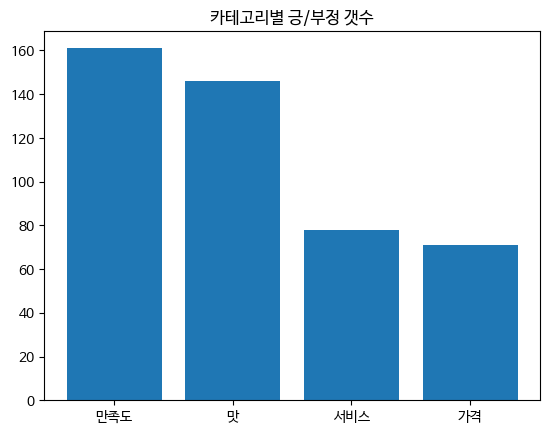

In [7]:
review_emote_bar(satisfaction_emote,taste_emote,service_emote,price_emote)

##### 원그래프 시각화

In [16]:
satisfy_emo = emotion_eval_counts(temp_review, "만족도")
taste_emo = emotion_eval_counts(temp_review, "맛")
service_emo = emotion_eval_counts(temp_review, "서비스")
price_emo = emotion_eval_counts(temp_review, "가격")

In [1]:
satisfy_total = satisfy_emo["긍정"] + satisfy_emo["부정"]
taste_total = taste_emo["긍정"] + taste_emo["부정"]
service_total = service_emo["긍정"] + service_emo["부정"]
price_total = price_emo["긍정"] + price_emo["부정"]

NameError: name 'satisfy_emo' is not defined

In [34]:
def percent_emotion(reviews, total_number):
    return reviews / total_number * 100

In [2]:
satisfy_positive = percent_emotion(satisfy_emo["긍정"], satisfy_total)
satisfy_negative = percent_emotion(satisfy_emo["부정"], satisfy_total)

price_positive = percent_emotion(price_emo["긍정"], price_total)
price_negative = percent_emotion(price_emo["부정"], price_total)


NameError: name 'percent_emotion' is not defined

In [157]:
import matplotlib.pyplot as plt

def pie_chart(positive, negative, keyword):
    ratio = [positive, negative]
    labels = ["긍정", "부정"]
    colors = ["#00539C", "#EEA47F"]
    plt.title("{} 긍/부정 비율".format(keyword))
    plt.pie(ratio, labels= labels, autopct='%.1f%%', colors = colors)
    plt.show()

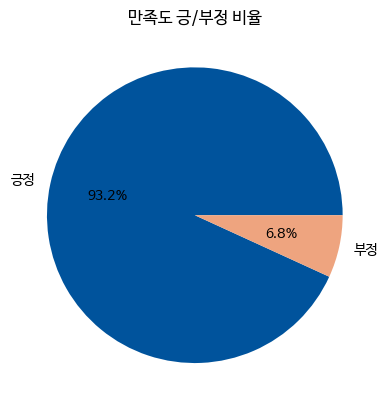

In [158]:
pie_chart(satisfy_positive, satisfy_negative, "만족도")

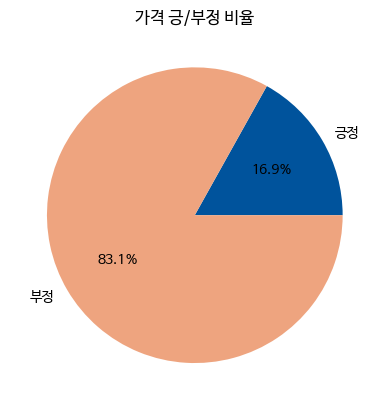

In [159]:
pie_chart(price_positive, price_negative, "가격")

#### 긍정 평가가 많은 카테고리, 부정 평가가 많은 카테고리 확인

- 긍정 평가가 많은 카테고리 = `만족도`
- 부정 평가가 많은 카테고리 = `가격`

#### 긍/부정평가가 많은 카테고리의 각 긍/부정 리뷰글만 추출하여 데이터 프레임 생성

##### 긍정이 많은 카테고리의 긍정 리뷰글만 추출

In [24]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [25]:
satisfy_reviews = {"긍정":[]}
# 만족도항목에 긍정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["만족도"][i] == "긍정":
        satisfy_reviews["긍정"].append(temp_review["Review_Text"][i])

In [26]:
# 리뷰글만 빼내어 문자열로 받기

for key, value in satisfy_reviews.items():
    satisfy_reviews[key] = ', '.join(value)
    
satisfy_positive_string = satisfy_reviews.get("긍정")
print(satisfy_positive_string[:20])

직원 분들 너무 친절하시고 음식 맛은


In [73]:
review_string1 = temp_review["Review_Text"].astype(str)

In [75]:
temp_string_reviews = {"ALL":[]}

for i in range(len(temp_review)):
    temp_string_reviews["ALL"].append(temp_review["Review_Text"][i])

In [77]:
for key, value in temp_string_reviews.items():
    temp_string_reviews[key] = ', '.join(value)
    
review_string1 = temp_string_reviews.get("ALL")

In [78]:
dessert_counts = review_string1.count("디저트")

print("만족도 카테고리의 긍정 리뷰글에서 디저트 키워드가 언급된 횟수는 {}회 입니다.".format(dessert_counts))

만족도 카테고리의 긍정 리뷰글에서 디저트 키워드가 언급된 횟수는 29회 입니다.


In [83]:


def review_emote_bar(counts):
    """카테고리 1개인 막대그래프 만드는 함수"""
    x = np.arange(1)

    y_axis = [counts]
    x_axis = ["디저트"]
    
    plt.figure(figsize = (4,6))
    bar = plt.bar(x,y_axis, width=0.2)
    plt.xticks(x, x_axis)
    plt.ylabel("횟수")
    plt.xlabel("카테고리")
    plt.xlim(-0.5,0.5)
    plt.title("디저트 키워드가 언급된 횟수")
    
    for rect in bar:
        height =rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center',va='bottom',size=12)
    plt.show()

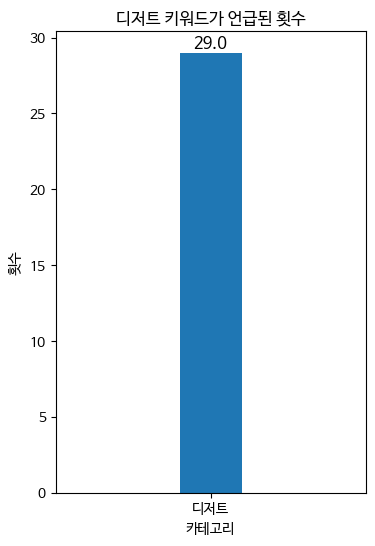

In [84]:
review_emote_bar(dessert_counts)

##### 부정이 많은 카테고리의 부정 리뷰글만 추출

In [120]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [121]:
price_reviews = {"부정":[]}
# 가격항목에 부정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["가격"][i] == "부정":
        price_reviews["부정"].append(temp_review["Review_Text"][i])

In [122]:
# 리뷰글만 빼내어 문자열로 받기

for key, value in price_reviews.items():
    price_reviews[key] = ', '.join(value)
    
price_negative_string = price_reviews.get("부정")
print(price_negative_string[:20])

신라호텔 파크뷰 조식 이용했습니다 1


#### 각각의 긍/부정 리뷰글들의 명사 추출, 동사/형용사추출 및 시각화

##### 긍정 리뷰글의 명사추출 및 시각화

In [110]:
# 명사 추출
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [15]:
satisfy_reviews_noun = kiwi_noun_extractor(satisfy_positive_string)

In [20]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("만족도 긍정 리뷰글의 명사모음", fontdict=title_font)
    plt.show()

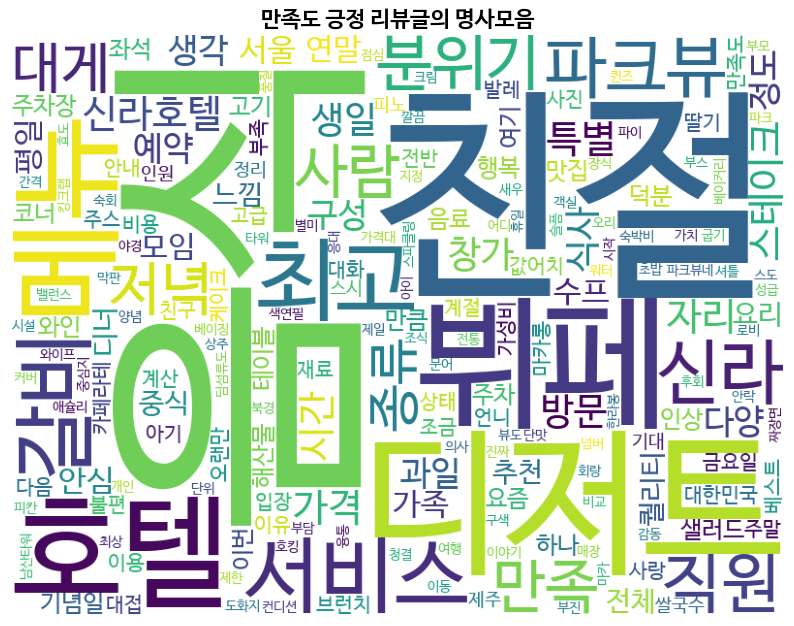

In [21]:
wordcloud_noun(satisfy_reviews_noun)

##### 긍정 리뷰글의 동사/형용사 추출및 시각화

In [111]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [112]:
satisfy_reviews_verb_adj = kiwi_verb_adj_extractor(satisfy_positive_string)

In [113]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
    plt.title("만족도 긍정 리뷰글의 동사/형용사 모음", fontdict=title_font)
    plt.show()

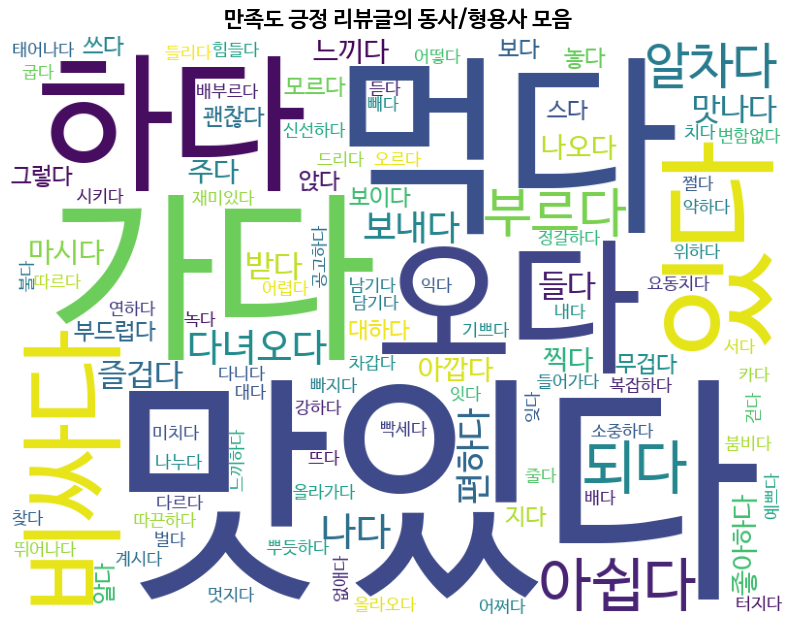

In [114]:
wordcloud_verb_adj(satisfy_reviews_verb_adj)

##### 부정리뷰글의 명사추출 및 시각화

In [22]:
# 명사 추출
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [23]:
price_reviews_noun = kiwi_noun_extractor(price_negative_string)

In [28]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    title_font = {
        'fontsize': 16,
        'fontweight': 'bold'
    }
    plt.title("가격 부정 리뷰글의 명사모음", fontdict=title_font)
    plt.show()

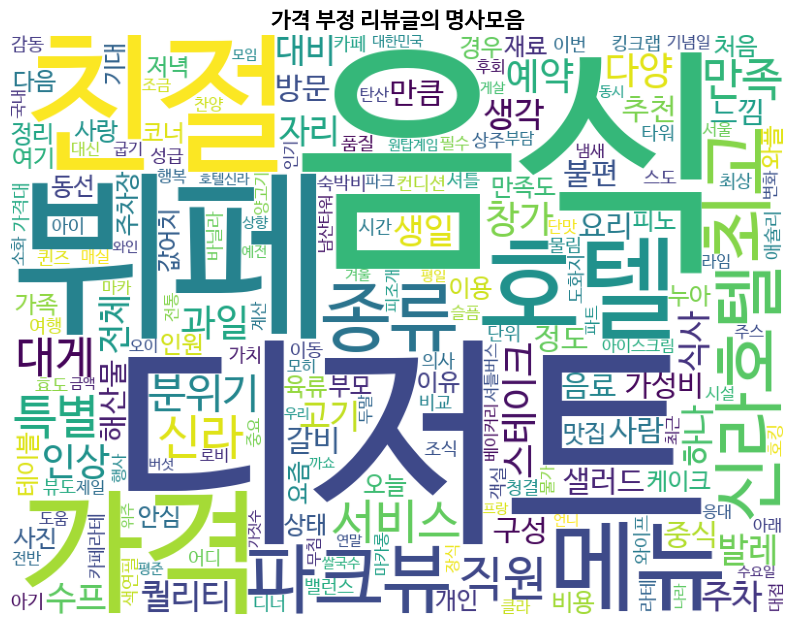

In [29]:
wordcloud_noun(price_reviews_noun)

##### 부정리뷰글의 동사/형용사추출 및 시각화

In [123]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [124]:
price_reviews_verb_adj = kiwi_verb_adj_extractor(price_negative_string)

In [125]:
# 워드클라우드시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    title_font = {
        'fontsize': 16,
        'fontweight': 'bold'
    }
    plt.title("가격 부정 리뷰글의 동사/형용사 모음", fontdict=title_font)
    plt.show()

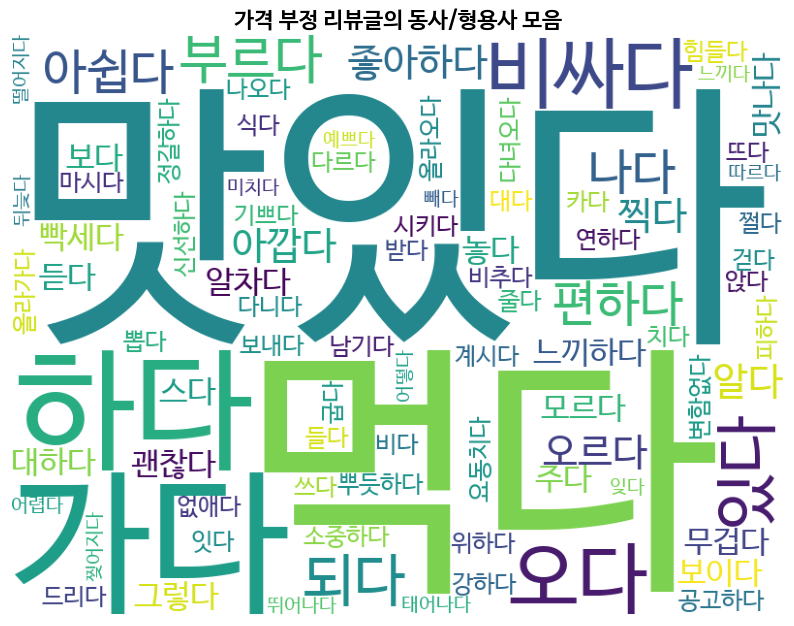

In [126]:
wordcloud_verb_adj(price_reviews_verb_adj)

#### `만족도` 긍정 리뷰글, `가격` 부정 리뷰글 빈도수 제일 많은 3개의 명사 추출 및 긍정/부정 분류

##### 만족도 긍정 리뷰글 추출

In [49]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [50]:
satisfy_reviews = {"긍정":[]}
# 만족도항목에 긍정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["만족도"][i] == "긍정":
        satisfy_reviews["긍정"].append(temp_review["Review_Text"][i])

In [70]:
satisfy_review_df = pd.DataFrame(satisfy_reviews)
satisfy_review_df.head()

긍정
0  직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...
1                                  종류도 알차게 많고 다 맛있어요
2  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...
3  창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...
4                                  항상 친절하시고 음식도 맛있네요

##### `만족도` 긍정 리뷰글 빈도 높은 명사 긍정/ 부정 분류

In [64]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_satisfy_positive_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"디저트": [], "음식":[], "친절":[]}
    for sentence in df["긍정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["디저트"].append(test_result["디저트"])
        temp["음식"].append(test_result["음식"])
        temp["친절"].append(test_result["친절"])

    df["디저트"] = temp["디저트"]
    df["음식"] = temp["음식"]
    df["친절"] = temp["친절"]

    
    df.to_csv("./satisfy_review_nouns_emotion_classify.csv", index = False)
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '디저트', '음식', '친절'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "디저트": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "친절": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [65]:
# 실행

chain = MyChain(template=template)

satisfy_positive_parse_review = save_satisfy_positive_reviews(satisfy_review_df, chain)

##### 가격 부정 리뷰글 추출

In [66]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [67]:
price_reviews = {"부정":[]}
# 만족도항목에 긍정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["가격"][i] == "부정":
        price_reviews["부정"].append(temp_review["Review_Text"][i])

In [69]:
price_review_df = pd.DataFrame(price_reviews)
price_review_df.head()

부정
0  신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...
1  분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...
2  부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...
3  신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...
4            네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집

##### `가격` 부정 리뷰글 빈도 높은 명사 긍정/부정 분류

In [71]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_price_negative_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"뷔페": [], "음식":[], "디저트":[]}
    for sentence in df["부정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["뷔페"].append(test_result["뷔페"])
        temp["음식"].append(test_result["음식"])
        temp["디저트"].append(test_result["디저트"])

    df["뷔페"] = temp["뷔페"]
    df["음식"] = temp["음식"]
    df["디저트"] = temp["디저트"]

    
    df.to_csv("./price_review_nouns_emotion_classify.csv", index = False)
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '뷔페', '음식', '디저트'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "뷔페": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "디저트": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [72]:
# 실행

chain = MyChain(template=template)

price_negative_parse_review = save_price_negative_reviews(price_review_df, chain)

##### 빈도 높은 명사들의 총 긍/부정 갯수 구하기

- `만족도` 긍정 리뷰글 빈도 높은 명사

In [ ]:
def emotion_eval_counts(df, column_name):
    return df[column_name].value_counts()

In [111]:
dessert_pos_emo = emotion_eval_counts(satisfy_positive_parse_review, "디저트")
food_pos_emo = emotion_eval_counts(satisfy_positive_parse_review, "음식")
kindness_emo = emotion_eval_counts(satisfy_positive_parse_review, "친절")

In [88]:
print(dessert_pos_emo)
print(food_pos_emo)
print(kindness_emo)

디저트
-     89
긍정    55
부정     6
Name: count, dtype: int64
음식
긍정    129
-      14
부정      7
Name: count, dtype: int64
친절
긍정    92
-     53
부정     5
Name: count, dtype: int64


In [188]:
def noun_emote_bar(emote1,emote2,emote3, column_name1, column_name2, column_name3, keyword):
    """명사 3개인 막대그래프 만드는 함수"""
    x = np.arange(3)
    
    All_emo1 = emote1["긍정"] + emote1["부정"]
    All_emo2 = emote2["긍정"] + emote2["부정"]
    All_emo3 = emote3["긍정"] + emote3["부정"]

    
    y_axis = [All_emo1,All_emo2,All_emo3]
    x_axis = [column_name1, column_name2, column_name3]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.title("{} 긍/부정 갯수".format(keyword))
    plt.show()

In [ ]:
noun_emote_bar(dessert_pos_emo,food_pos_emo,kindness_emo,"디저트","음식","친절","빈도 높은 명사들")

- `가격` 부정 리뷰글 빈도 높은 명사

In [112]:
buffet_emo = emotion_eval_counts(price_negative_parse_review, "뷔페")
food_neg_emo = emotion_eval_counts(price_negative_parse_review, "음식")
dessert_neg_emo = emotion_eval_counts(price_negative_parse_review, "디저트")

In [117]:
print(buffet_emo)
print(food_neg_emo)
print(dessert_neg_emo)

뷔페
긍정    30
-     15
부정    14
Name: count, dtype: int64
음식
긍정    45
부정    10
-      4
Name: count, dtype: int64
디저트
-     35
긍정    19
부정     5
Name: count, dtype: int64


In [ ]:
noun_emote_bar(buffet_emo, food_neg_emo, dessert_neg_emo, "뷔페", "음식", "디저트", "빈도 높은 명사")

##### 빈도 높은 명사 긍/부정 분류 시각화

In [167]:
# 긍/부정 총 갯수 구하기
dessert_pos_total= dessert_pos_emo["긍정"] + dessert_pos_emo["부정"]
food_pos_total=food_pos_emo["긍정"] + food_pos_emo["부정"]
kindness_total = kindness_emo["긍정"] + kindness_emo["부정"]

In [ ]:
def percent_emotion(reviews, total_number):
    return reviews / total_number * 100

In [170]:
dessert_positive_pos = percent_emotion(dessert_pos_emo["긍정"], dessert_pos_total)
food_positive_pos = percent_emotion(food_pos_emo["긍정"], food_pos_total)
kindness_pos = percent_emotion(kindness_emo["긍정"], kindness_total)


dessert_positive_neg = percent_emotion(dessert_pos_emo["부정"], dessert_pos_total)
food_positive_neg = percent_emotion(food_pos_emo["부정"], food_pos_total)
kindness_neg = percent_emotion(kindness_emo["부정"], kindness_total)

In [114]:
# 원그래프
import matplotlib.pyplot as plt

def pie_chart(positive, negative, keyword):
    ratio = [positive, negative]
    labels = ["긍정", "부정"]
    colors = ["#00539C", "#EEA47F"]
    plt.title("{} 긍/부정 비율".format(keyword))
    plt.pie(ratio, labels= labels, autopct='%.1f%%', colors = colors)
    plt.show()

- `만족도` 긍정 리뷰글 빈도 높은 명사들 긍/부정 비율

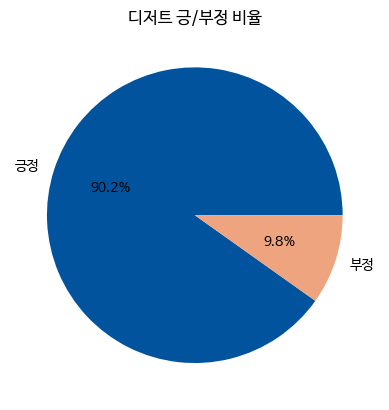

In [172]:
pie_chart(dessert_positive_pos, dessert_positive_neg, "디저트")

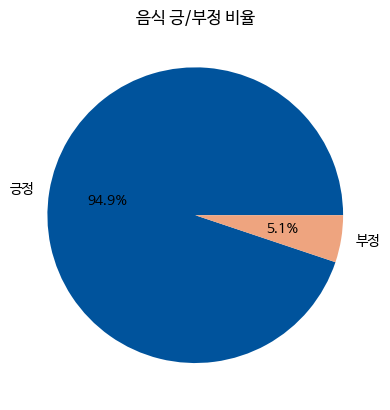

In [173]:
pie_chart(food_positive_pos, food_positive_neg, "음식")

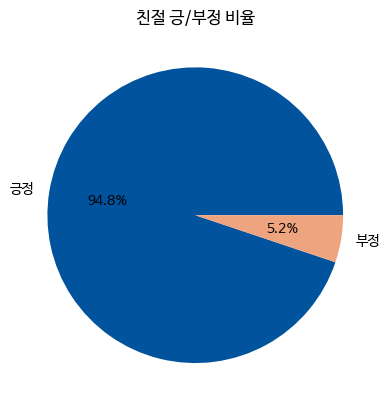

In [174]:
pie_chart(kindness_pos,kindness_neg,"친절")

- `가격` 부정 리뷰글 빈도 높은 명사들 긍/부정 비율

In [179]:
# 부정 리뷰글 총 긍/부정 갯수 구하기
buffet_total = buffet_emo["긍정"] + buffet_emo["부정"]
food_neg_total = food_neg_emo["긍정"] + food_neg_emo["부정"]
dessert_neg_total = dessert_neg_emo["긍정"] + dessert_neg_emo["부정"]

In [180]:
buffet_pos = percent_emotion(buffet_emo["긍정"], buffet_total)
food_negative_pos = percent_emotion(food_neg_emo["긍정"], food_neg_total)
dessert_negative_pos = percent_emotion(dessert_neg_emo["긍정"], dessert_neg_total)

buffet_neg = percent_emotion(buffet_emo["부정"], buffet_total)
food_negative_neg = percent_emotion(food_neg_emo["부정"], food_neg_total)
dessert_negative_neg = percent_emotion(dessert_neg_emo["부정"], dessert_neg_total)

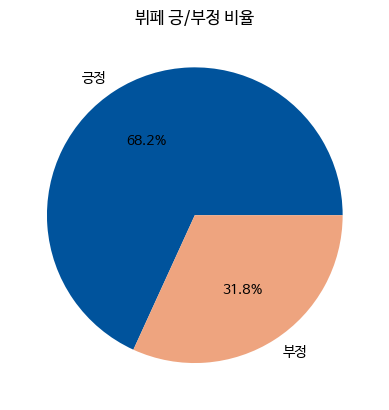

In [181]:
pie_chart(buffet_pos, buffet_neg,"뷔페")

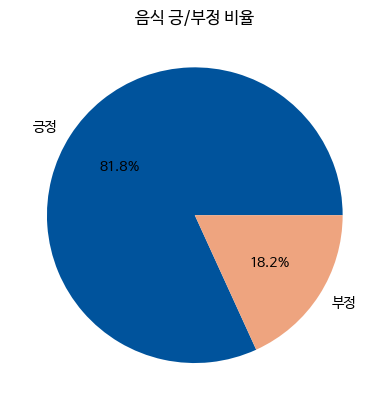

In [177]:
pie_chart(food_negative_pos, food_negative_neg, "음식")

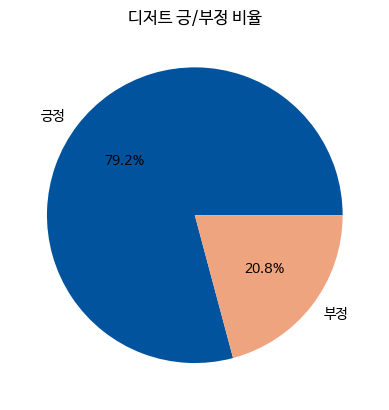

In [178]:
pie_chart(dessert_negative_pos, dessert_negative_neg, "디저트")

---

##### 키워드 갯수 구하기

In [4]:
import pandas as pd

In [5]:
temp_review_strlength = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")

In [6]:
review_strlist = temp_review_strlength["Review_Text"].to_list()
review_string = ''.join(str(s) for s in review_strlist)

In [9]:
review_string.count("디저트")
review_string.count("과일")
review_string.count("케이크")

2